In [1]:
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
import datetime
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import keras
from keras.layers import Input,Flatten,Dense,Reshape,Dropout
from keras.layers import BatchNormalization,Activation,ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D,Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 40 # For better results increase this value
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 8

# GENERATOR

In [5]:
def get_generator(z = (NOISE_SIZE,)):
    input_layer = Input(z)
    hid = Dense(4*4*512, activation='relu',name="Dense")(input_layer)
    hid = LeakyReLU(alpha = 0.2,name="Leakyrelu1")(hid)
    hid = Reshape((4,4,512))(hid)
    
    hid = Conv2DTranspose(512,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="trans_conv1")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON,name="Batch_norm1")(hid)
    hid = LeakyReLU(alpha=0.2,name="LeakyRelu2")(hid)
    
    hid = Conv2DTranspose(256,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="trans_conv2")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON,name="Batch_norm2")(hid)
    hid = LeakyReLU(alpha=0.2,name="LeakyRelu3")(hid)
    
    hid = Conv2DTranspose(128,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="trans_conv3")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON,name="Batch_norm3")(hid)
    hid = LeakyReLU(alpha=0.2,name="LeakyRelu4")(hid)
    
    hid = Conv2DTranspose(64,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="trans_conv4")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON,name="Batch_norm4")(hid)
    hid = LeakyReLU(alpha=0.2,name="LeakyRelu5")(hid)
    
    hid = Conv2DTranspose(3,kernel_size=[5,5],strides=[1,1],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="trans_conv_out")(hid)
    out = Activation("tanh",name="out")(hid)
    
    model = Model(inputs=input_layer,outputs=out)
    model.summary()
    
    return model

# DISCRIMINATOR

In [6]:
def get_discriminator(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)):
    input_layer = Input(input_shape)
    hid = Conv2D(32,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="conv1")(input_layer)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Conv2D(64,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="conv2")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Conv2D(128,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="conv3")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Conv2D(256,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="conv4")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Conv2D(512,kernel_size=[5,5],strides=[2,2],padding="same",kernel_initializer=keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name="conv5")(hid)
    hid = BatchNormalization(momentum=0.9,epsilon=EPSILON)(hid)
    hid = LeakyReLU(alpha=0.2)(hid)
    
    hid = Flatten(name="flatterrrrr")(hid)
    out = Dense(1,activation="sigmoid",name="discriminator_out")(hid)
    model = Model(inputs=input_layer,outputs=out)
    
    model.summary()
    return model

In [21]:
discriminator = get_discriminator((IMAGE_SIZE,IMAGE_SIZE,3))
discriminator.compile(loss="binary_crossentropy",optimizer=Adam(lr=LR_D),metrics=['accuracy'])

discriminator.trainable = False

generator = get_generator((NOISE_SIZE,))

gan_input = Input(shape=(NOISE_SIZE,))
x = generator(gan_input)
gan_out = discriminator(x)

gan = Model(inputs=gan_input,outputs=gan_out)
gan.summary()

gan.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR_G))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)        0         
__________

In [8]:
os.getcwd()

'C:\\Users\\AnKajVi\\Documents'

In [9]:
os.chdir('./faces')
os.getcwd()

'C:\\Users\\AnKajVi\\Documents\\faces'

In [10]:
INPUT_DATA_DIR = "C:/Users/Ankajvi/Documents/faces"

In [11]:
import matplotlib.image as mpimg

In [12]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
    plt.show()
    plt.close()

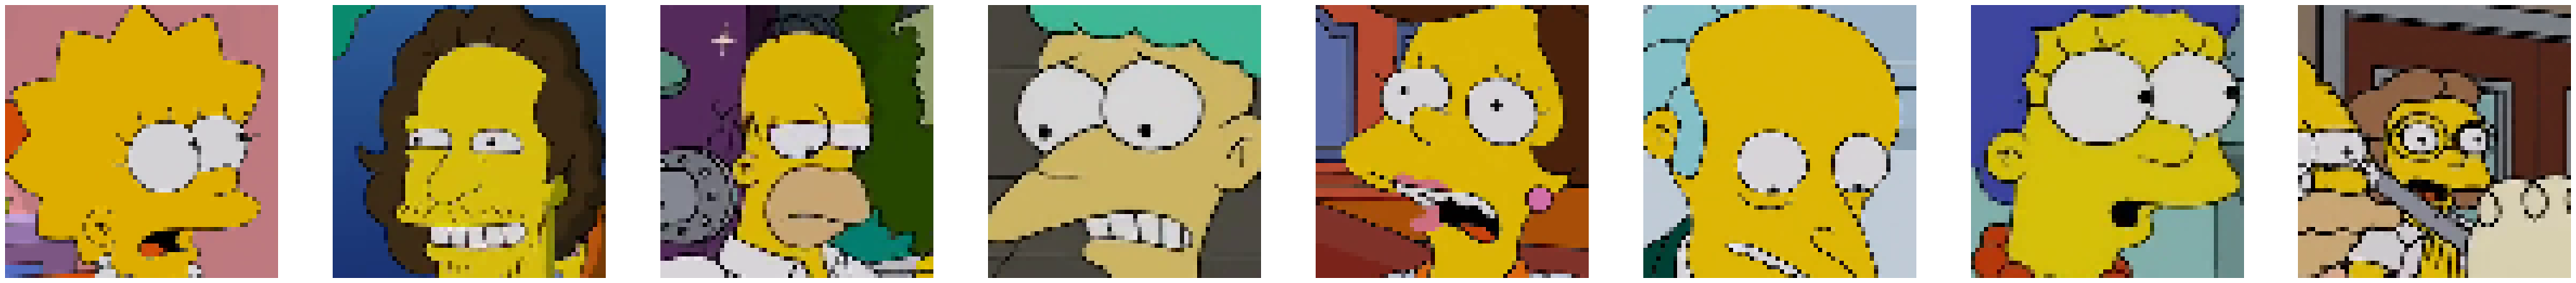

In [13]:
exclude_img=["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191",
"678","388","803"]
exclude_img = [s + ".png" for s in exclude_img]

input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE,IMAGE_SIZE))) for file in os.listdir(INPUT_DATA_DIR) if file not in exclude_img])

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)

show_samples(sample_images)

In [37]:
def test(input_z):
    samples = generator.predict(input_z[:SAMPLES_TO_SHOW])
    sample_images = [((sample+1)*127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images)

In [44]:
def summarize_epochs(d_losses,g_losses,data_shape,epoch,duration,input_z):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epochs {}/{}".format(epoch,EPOCHS))
    print("Duration: {:.3f}".format(duration))
    print("DISCRIMINATOR LOSS: {:.5f}".format(np.mean(d_losses)))
    print("GENERATOR LOSS: {:.5f}".format(np.mean(g_losses)))
    #fig, ax = plt.subplots()
    #plt.plot(d_losses, label='Discriminator', alpha=0.6)
    #plt.plot(g_losses, label='Generator', alpha=0.6)
    #plt.title("Losses")
    #plt.legend()
    #plt.show()
    #plt.close()
    test(input_z)

In [16]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return np.array(batches)

### TRAINING

TRAINING BEGINS...
Epochs 1/40
Duration: 83.989
DISCRIMINATOR LOSS: 0.22373
GENERATOR LOSS: 2.95095


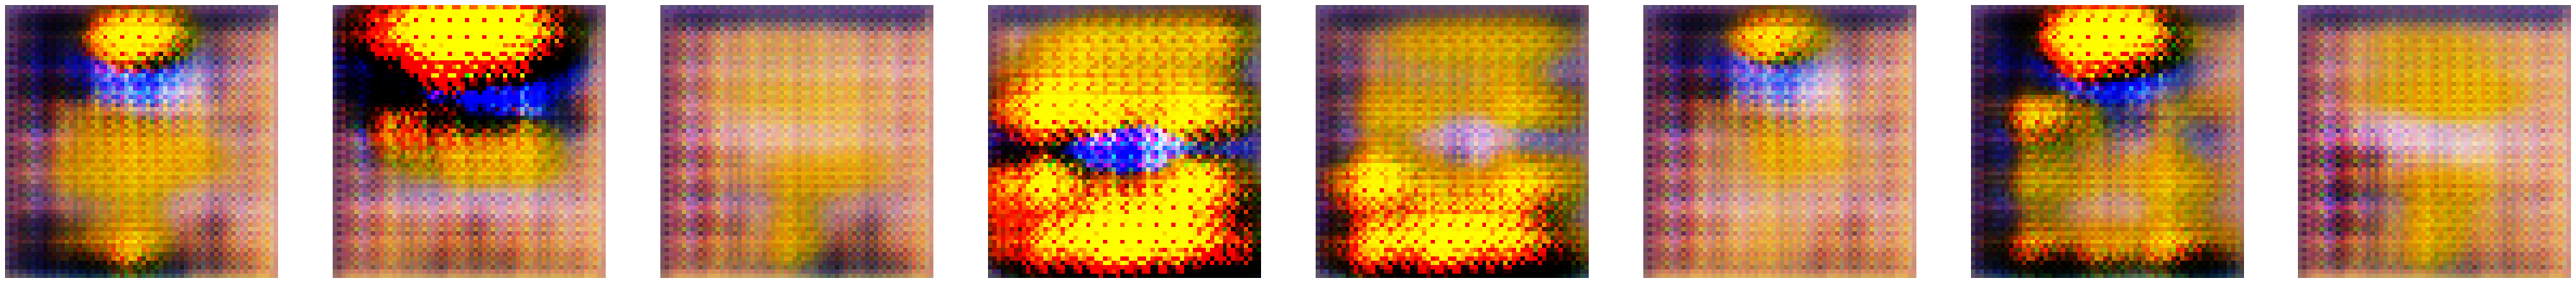

Epochs 2/40
Duration: 85.877
DISCRIMINATOR LOSS: 0.22196
GENERATOR LOSS: 3.03365


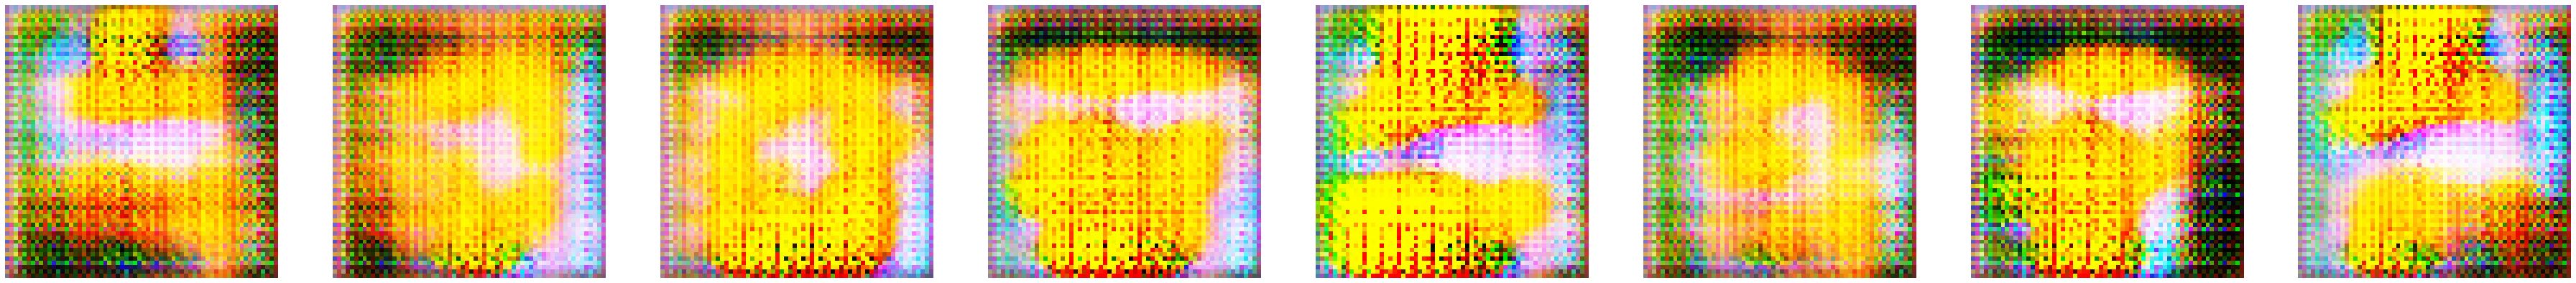

Epochs 3/40
Duration: 85.286
DISCRIMINATOR LOSS: 0.22193
GENERATOR LOSS: 3.09701


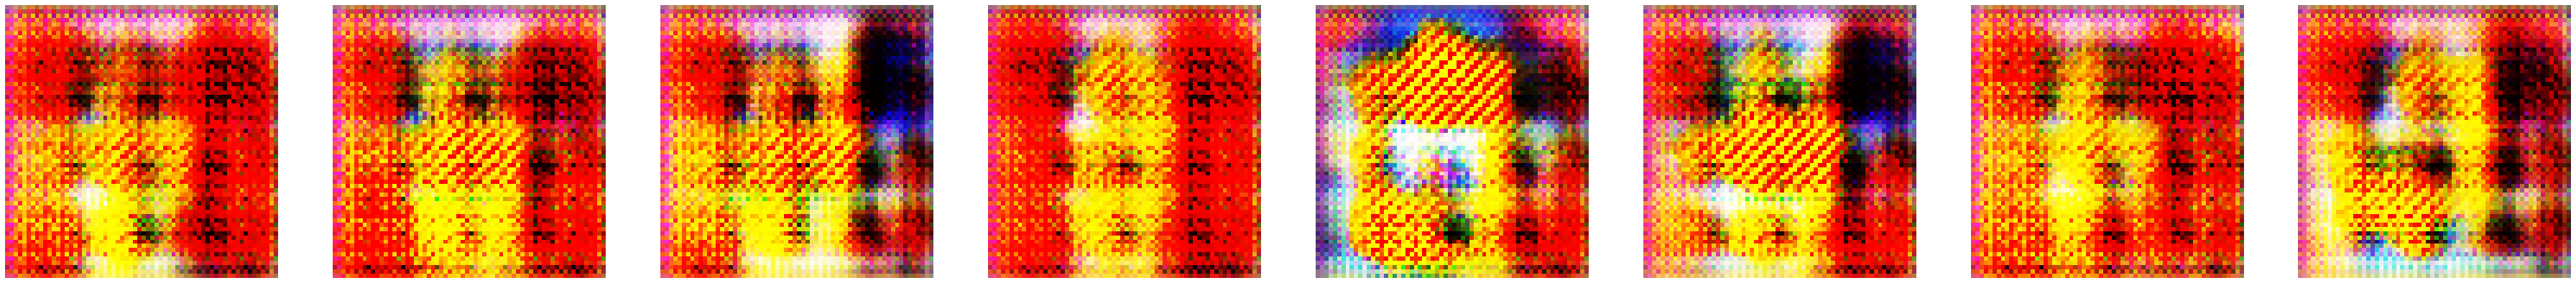

Epochs 4/40
Duration: 85.517
DISCRIMINATOR LOSS: 0.22050
GENERATOR LOSS: 3.06896


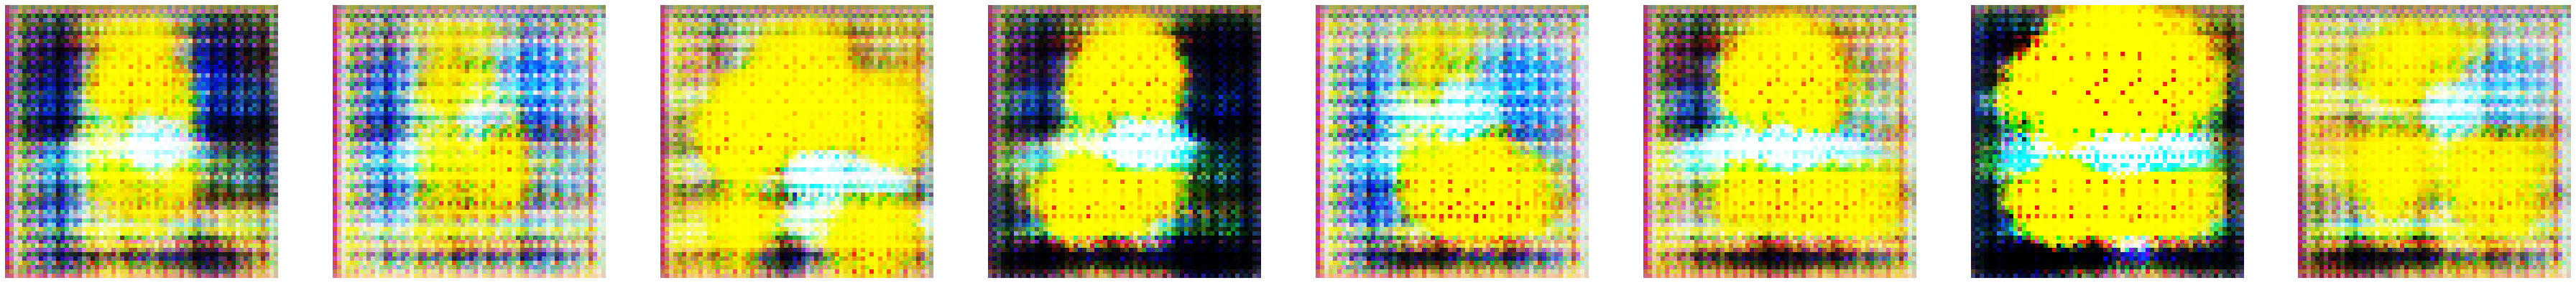

Epochs 5/40
Duration: 84.536
DISCRIMINATOR LOSS: 0.22067
GENERATOR LOSS: 3.06547


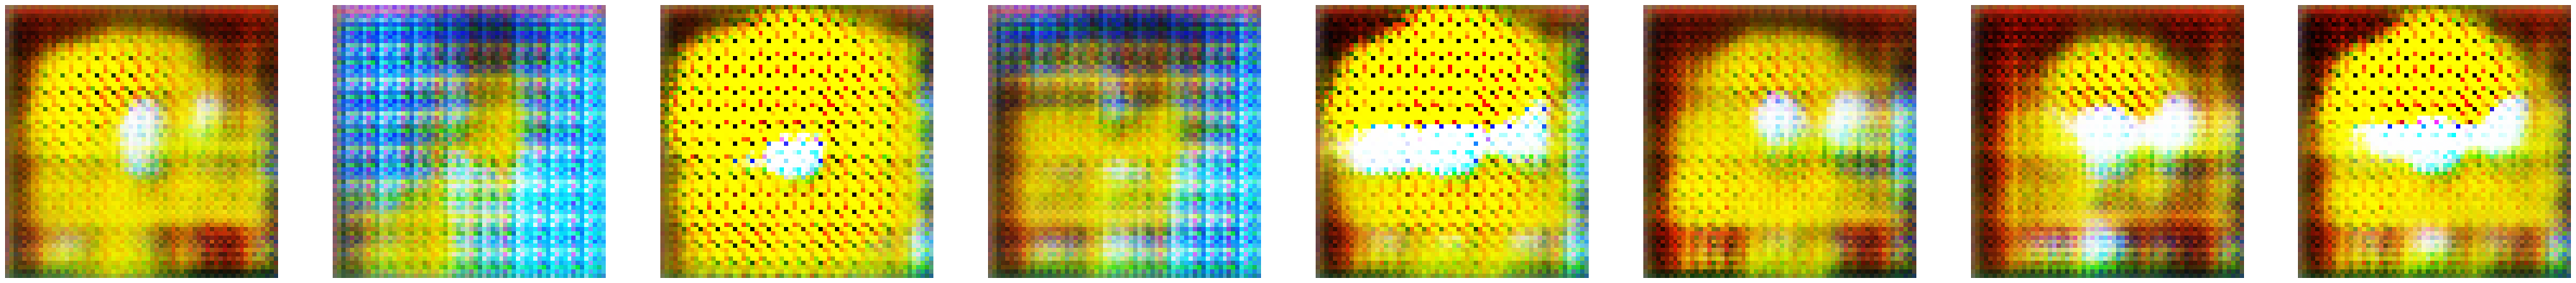

Epochs 6/40
Duration: 83.874
DISCRIMINATOR LOSS: 0.22070
GENERATOR LOSS: 3.04844


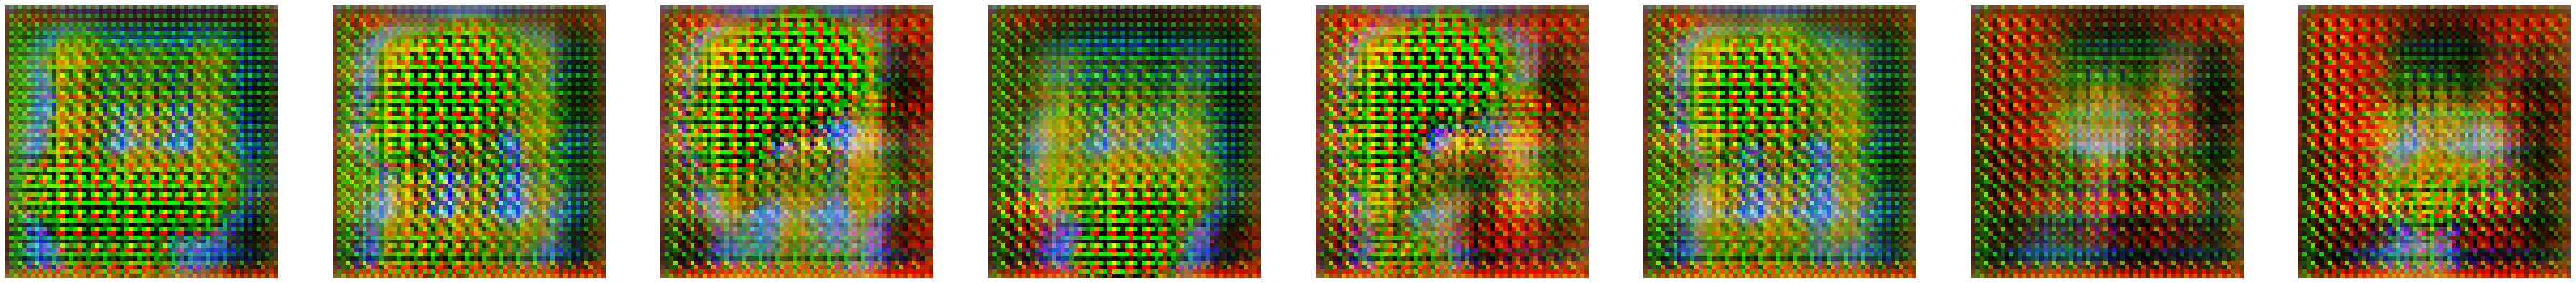

Epochs 7/40
Duration: 84.132
DISCRIMINATOR LOSS: 0.22161
GENERATOR LOSS: 3.04045


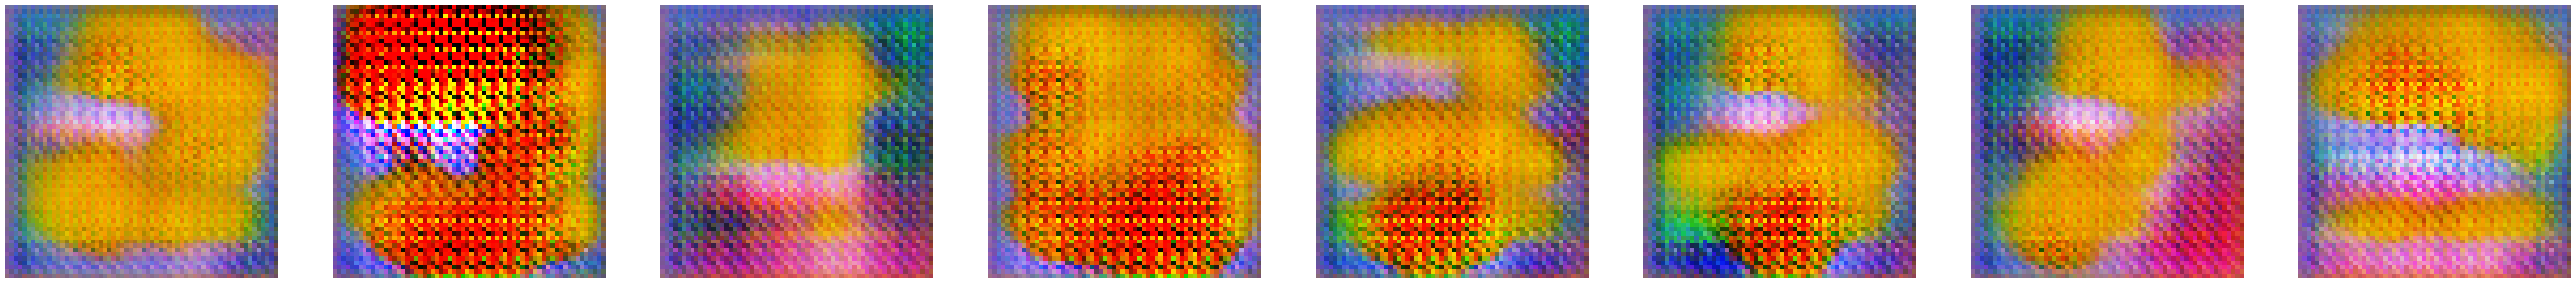

Epochs 8/40
Duration: 85.842
DISCRIMINATOR LOSS: 0.22162
GENERATOR LOSS: 3.04635


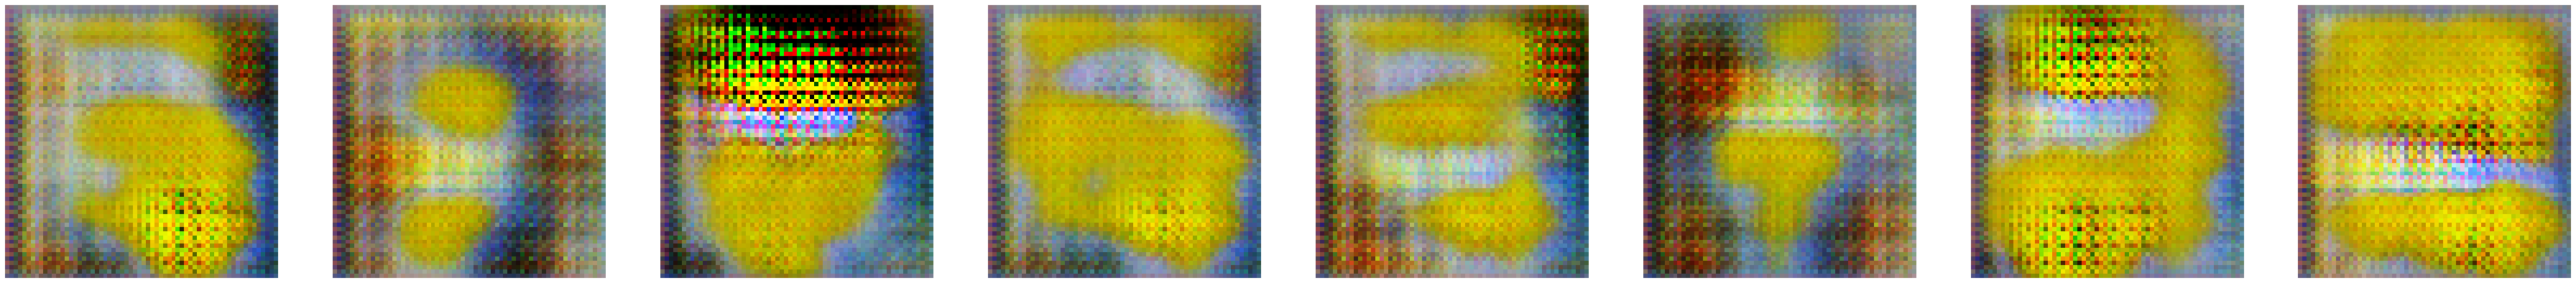

Epochs 9/40
Duration: 84.541
DISCRIMINATOR LOSS: 0.22267
GENERATOR LOSS: 3.04669


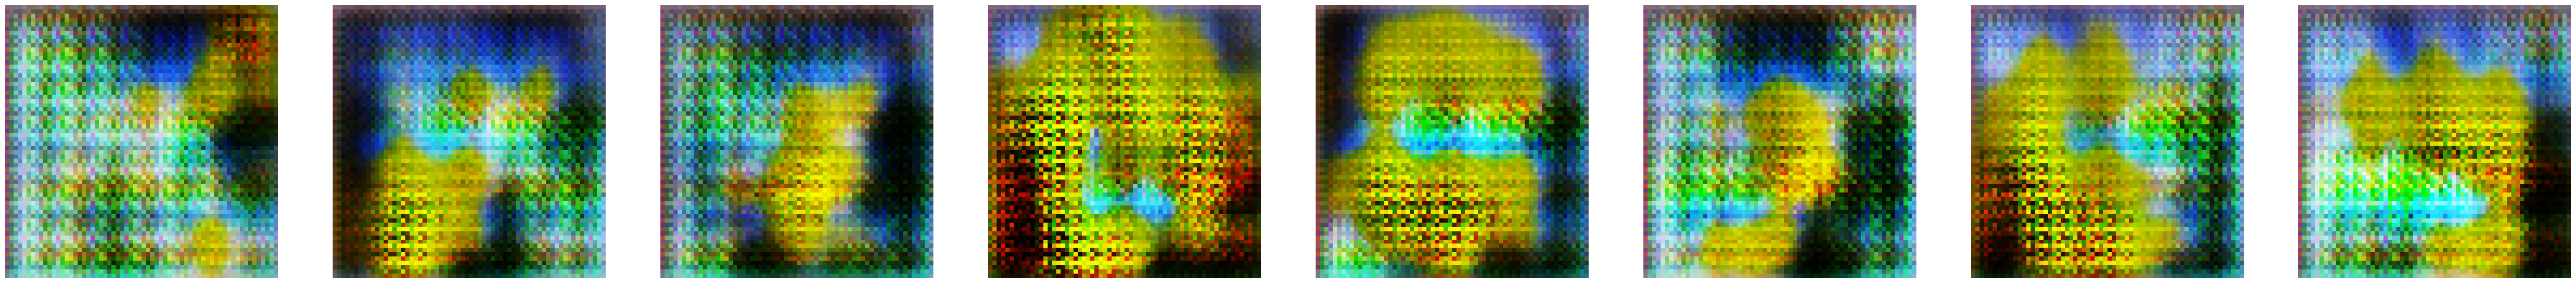

Epochs 10/40
Duration: 84.306
DISCRIMINATOR LOSS: 0.22457
GENERATOR LOSS: 3.05114


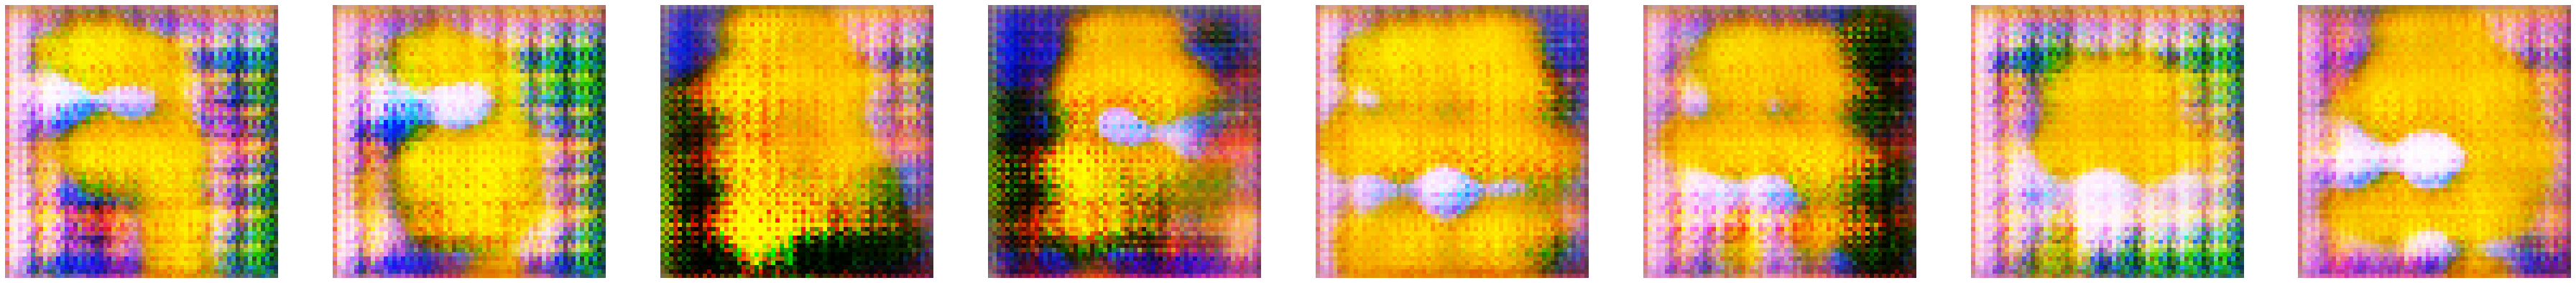

Epochs 11/40
Duration: 83.814
DISCRIMINATOR LOSS: 0.22536
GENERATOR LOSS: 3.05111


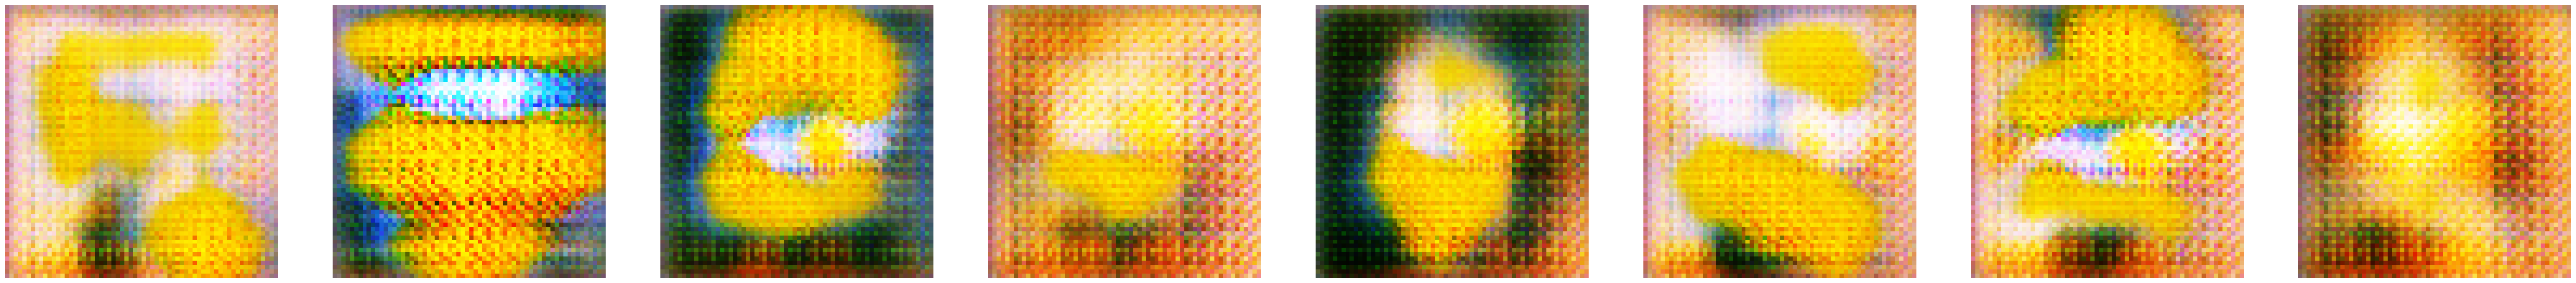

Epochs 12/40
Duration: 84.874
DISCRIMINATOR LOSS: 0.22569
GENERATOR LOSS: 3.04825


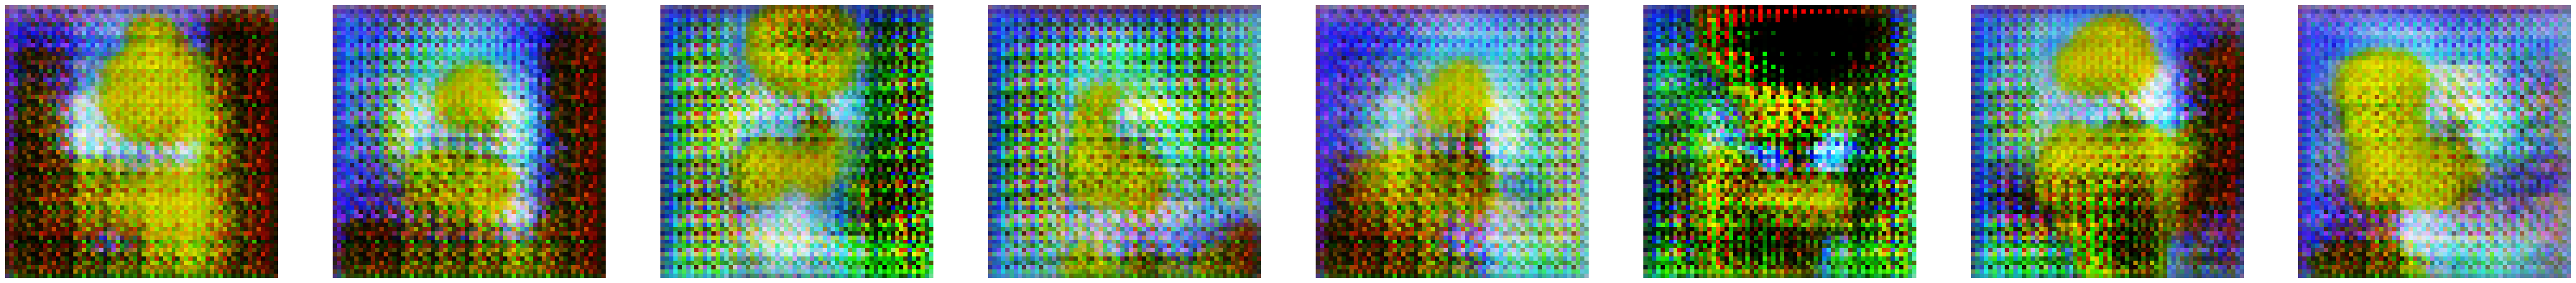

Epochs 13/40
Duration: 84.735
DISCRIMINATOR LOSS: 0.22606
GENERATOR LOSS: 3.03256


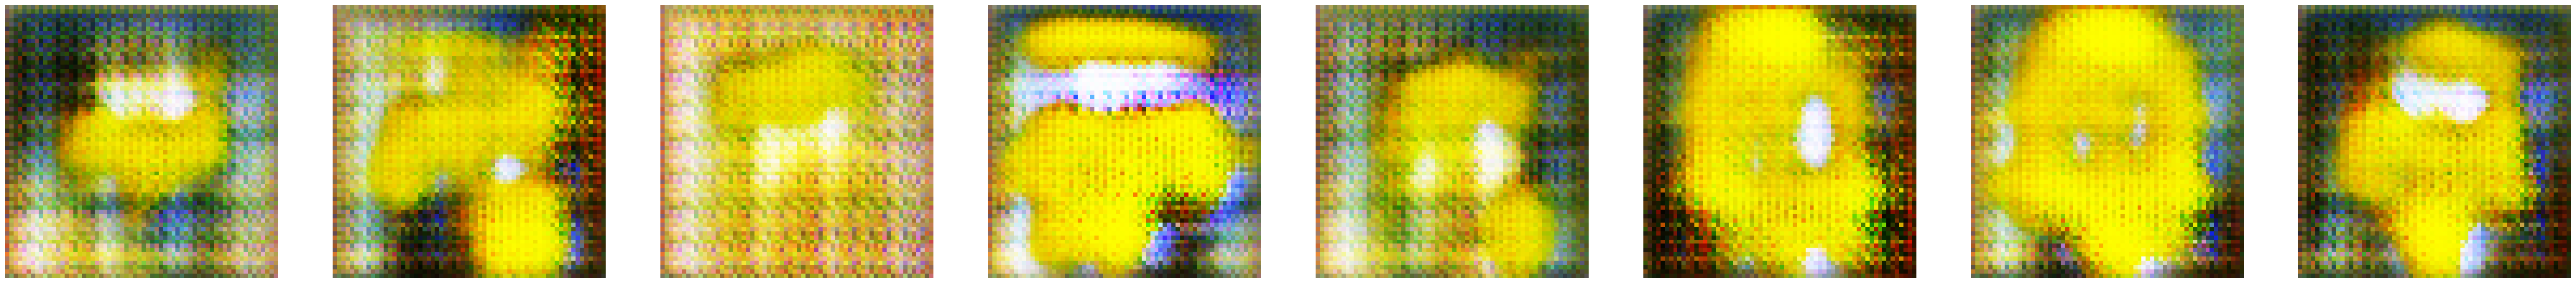

Epochs 14/40
Duration: 83.762
DISCRIMINATOR LOSS: 0.22637
GENERATOR LOSS: 3.02767


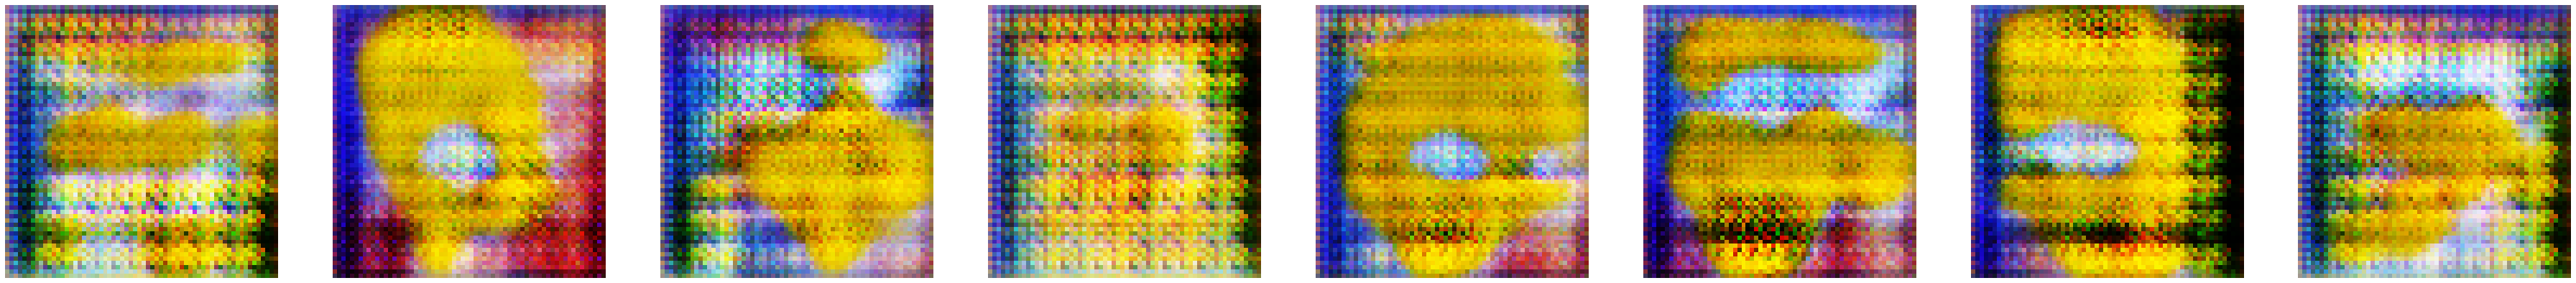

Epochs 15/40
Duration: 83.781
DISCRIMINATOR LOSS: 0.22749
GENERATOR LOSS: 3.03817


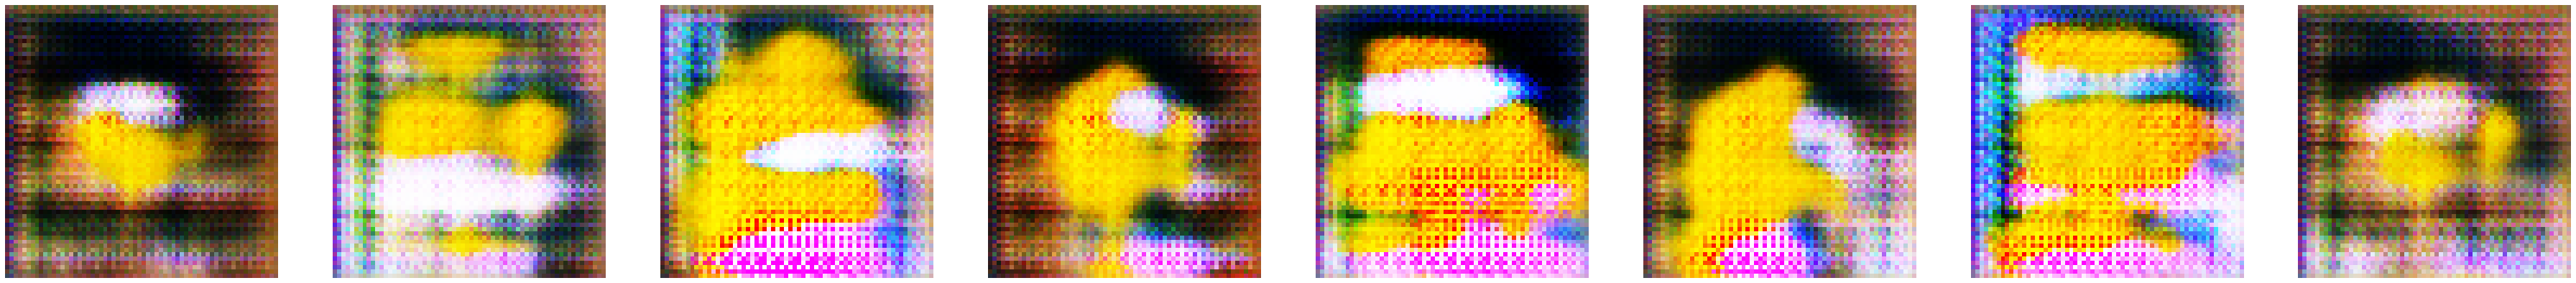

Epochs 16/40
Duration: 84.031
DISCRIMINATOR LOSS: 0.22756
GENERATOR LOSS: 3.03343


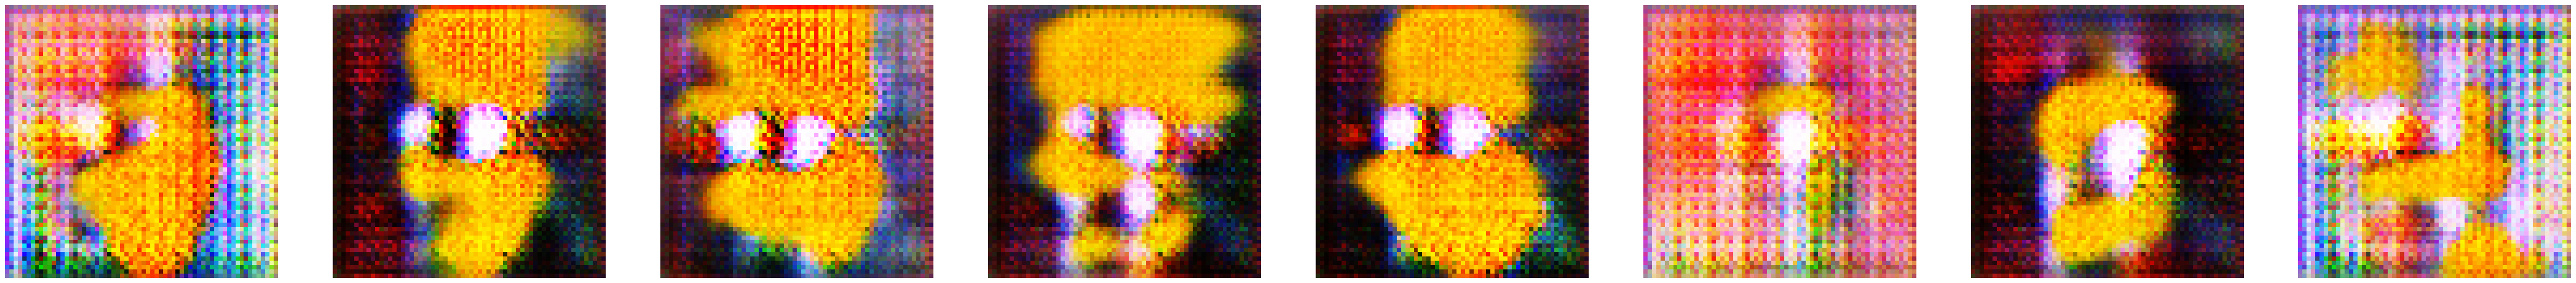

Epochs 17/40
Duration: 84.130
DISCRIMINATOR LOSS: 0.22793
GENERATOR LOSS: 3.03327


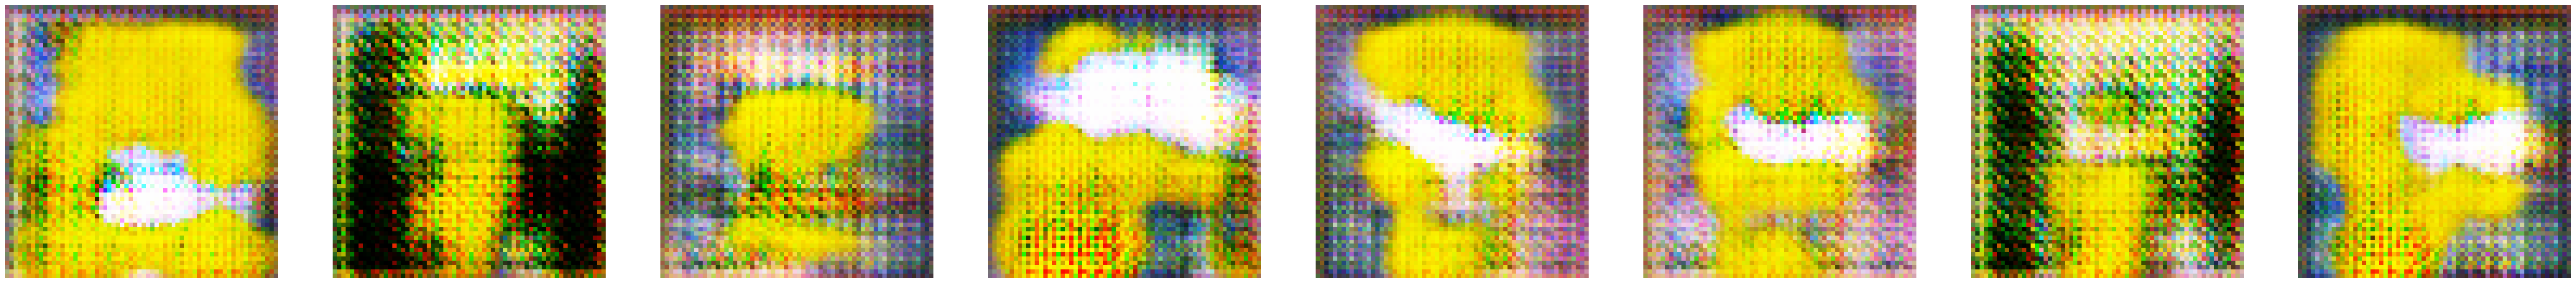

Epochs 18/40
Duration: 83.941
DISCRIMINATOR LOSS: 0.22869
GENERATOR LOSS: 3.02721


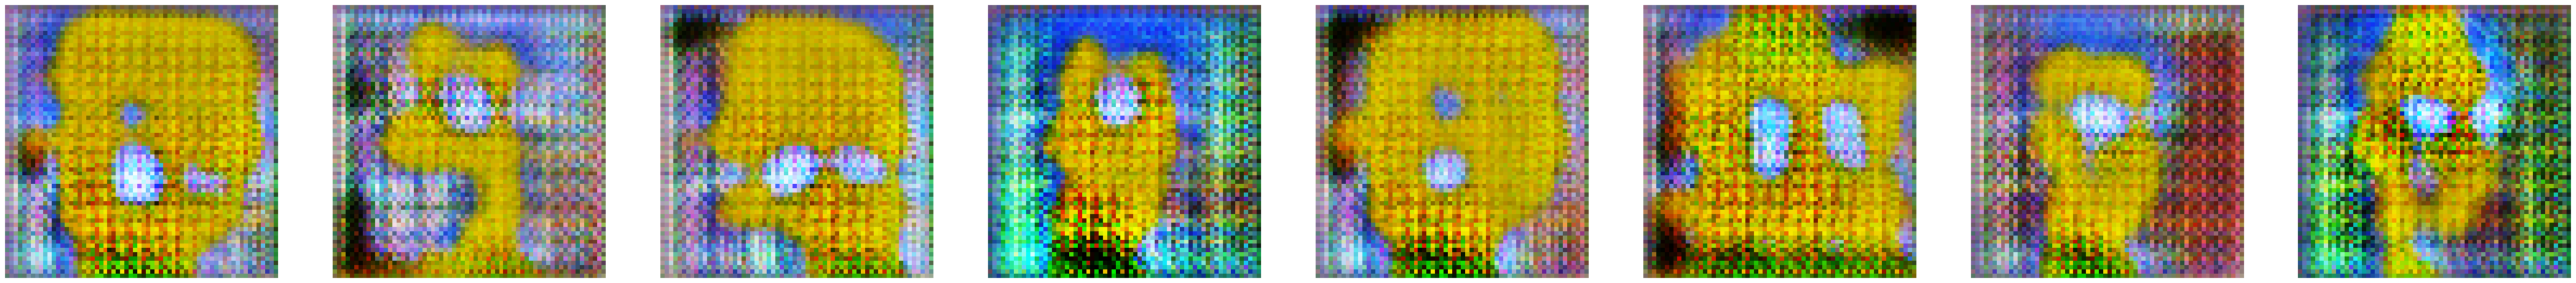

Epochs 19/40
Duration: 83.889
DISCRIMINATOR LOSS: 0.22953
GENERATOR LOSS: 3.02491


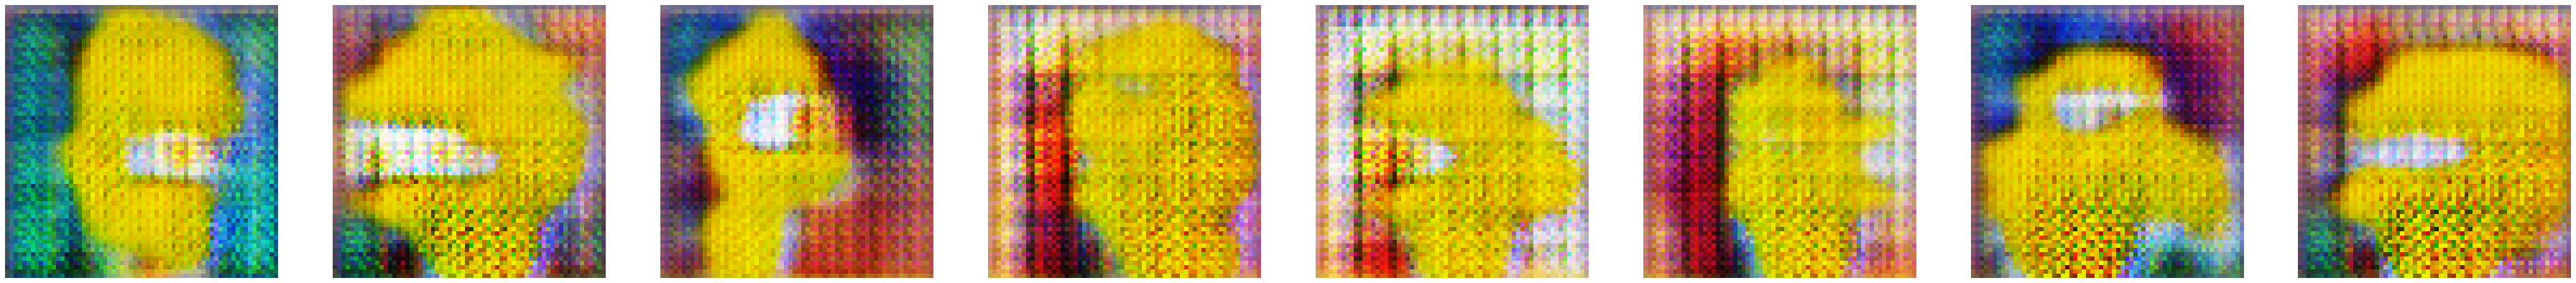

Epochs 20/40
Duration: 84.157
DISCRIMINATOR LOSS: 0.23003
GENERATOR LOSS: 3.02279


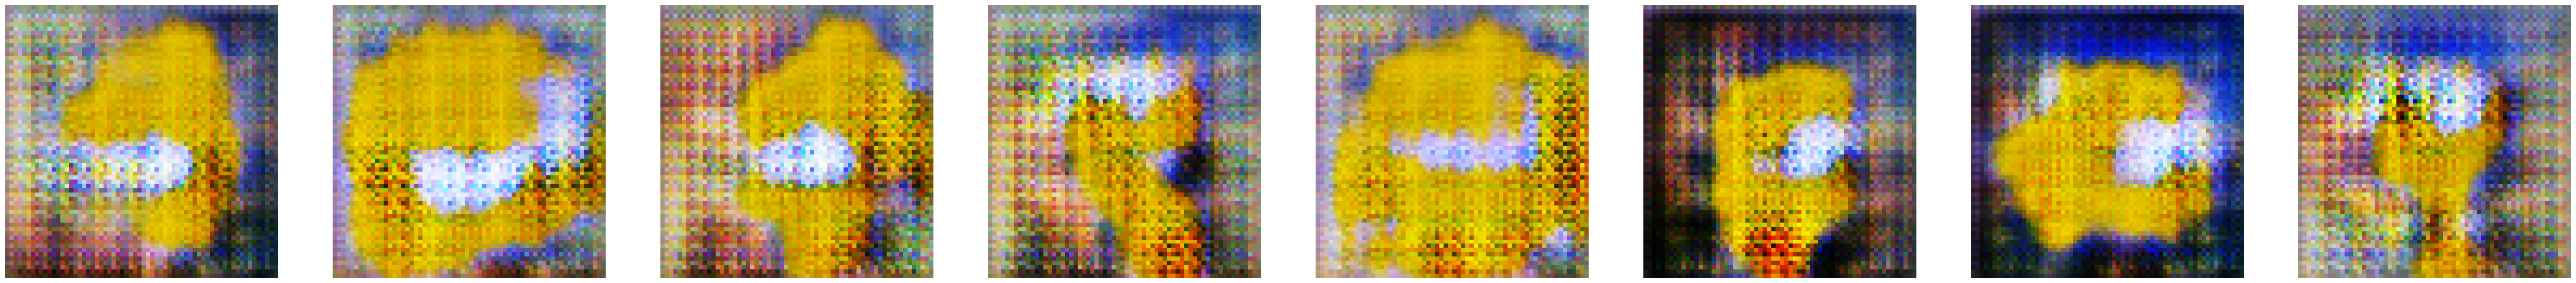

Epochs 21/40
Duration: 83.970
DISCRIMINATOR LOSS: 0.23051
GENERATOR LOSS: 3.02671


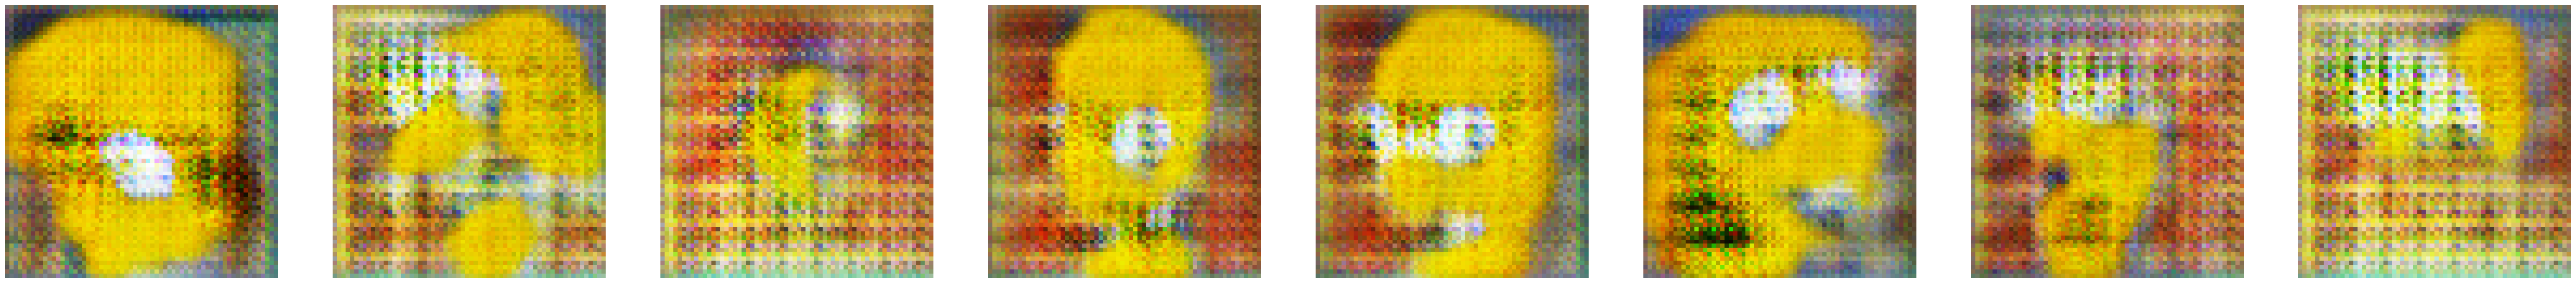

Epochs 22/40
Duration: 83.856
DISCRIMINATOR LOSS: 0.23133
GENERATOR LOSS: 3.02626


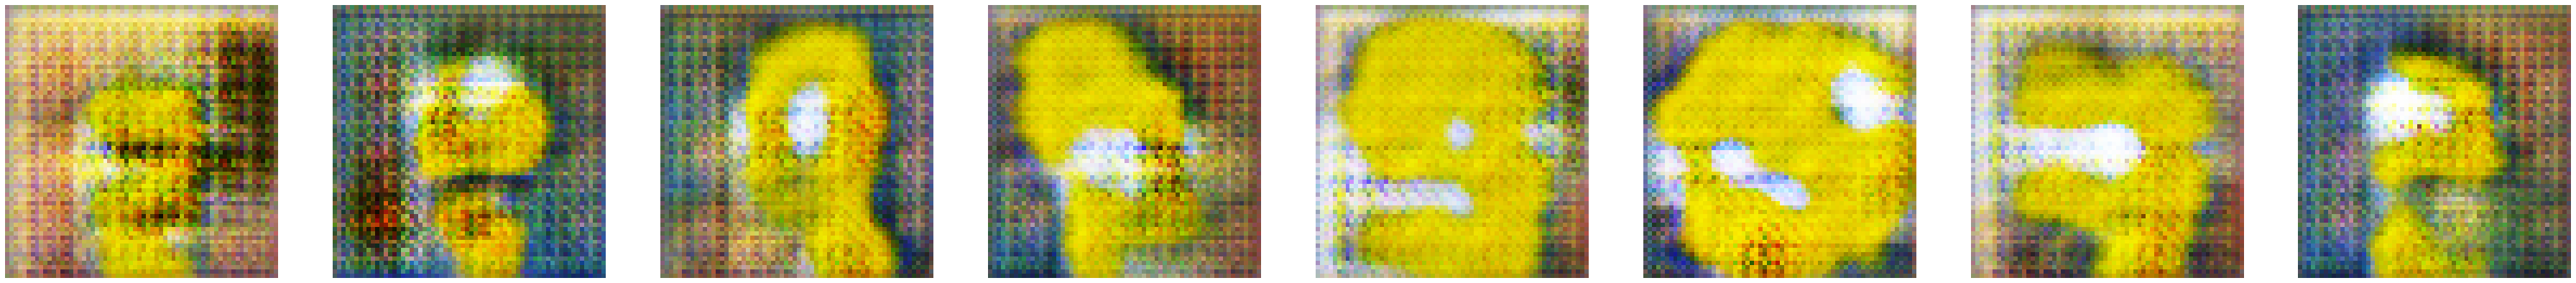

Epochs 23/40
Duration: 84.230
DISCRIMINATOR LOSS: 0.23165
GENERATOR LOSS: 3.01975


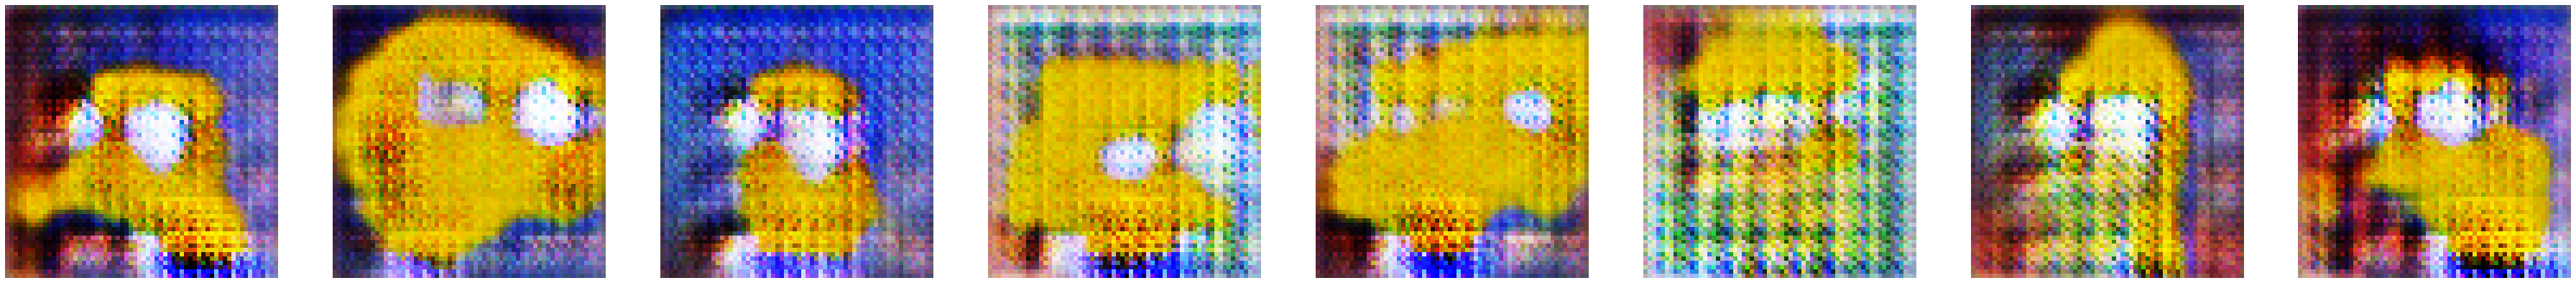

Epochs 24/40
Duration: 84.220
DISCRIMINATOR LOSS: 0.23215
GENERATOR LOSS: 3.01585


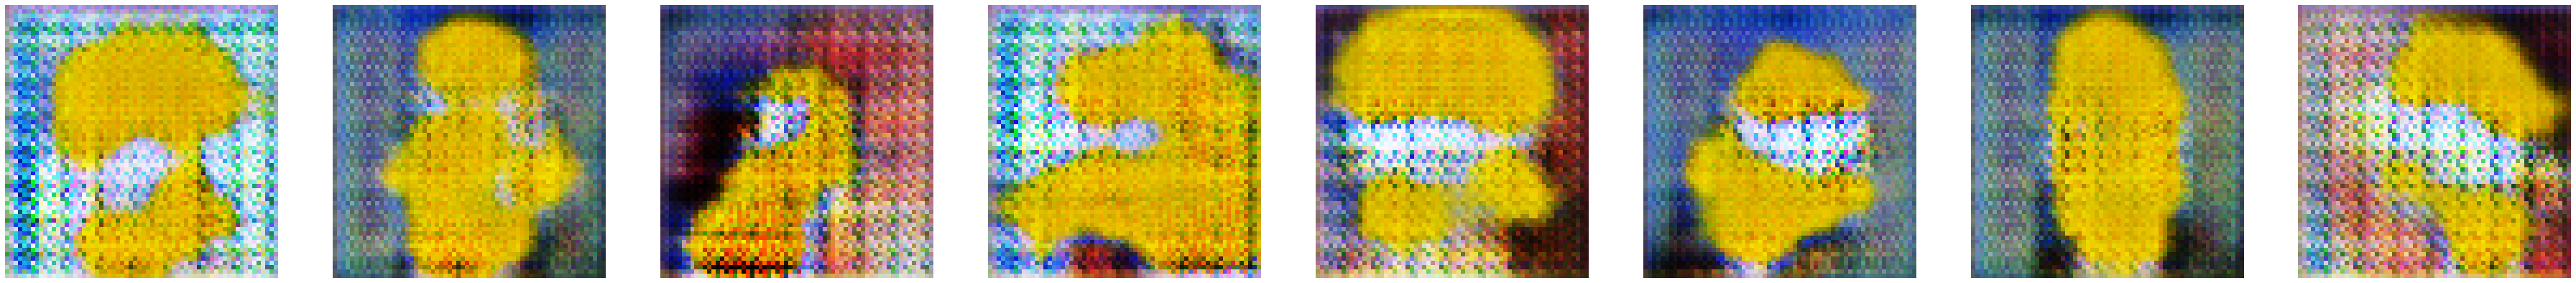

Epochs 25/40
Duration: 84.020
DISCRIMINATOR LOSS: 0.23289
GENERATOR LOSS: 3.01491


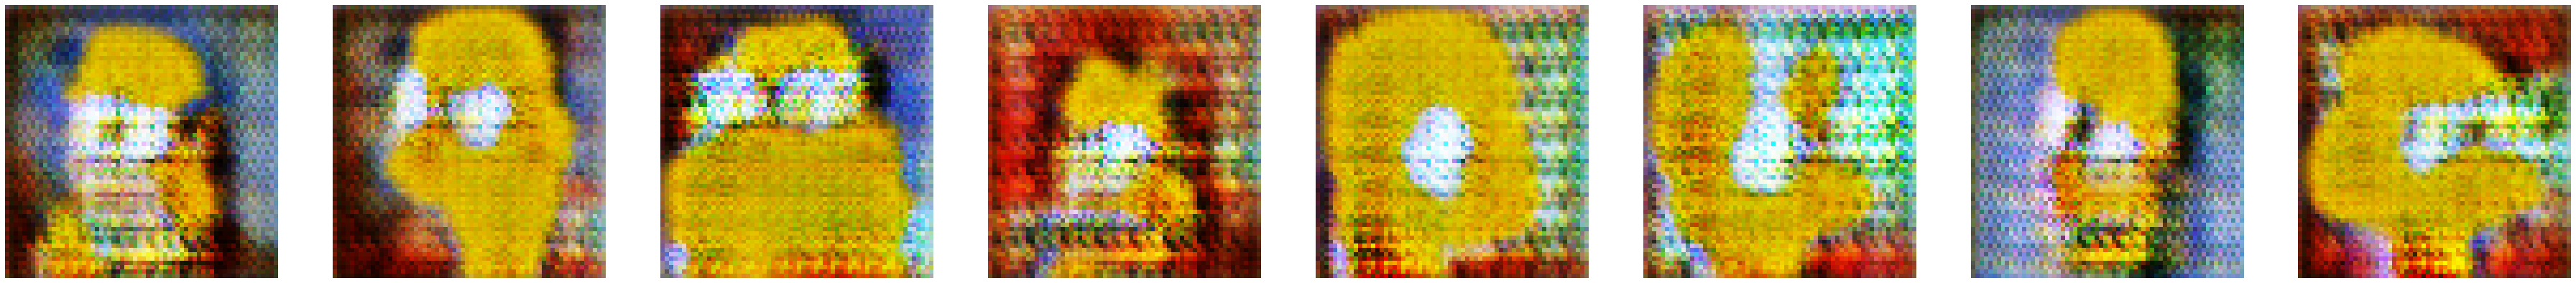

Epochs 26/40
Duration: 83.981
DISCRIMINATOR LOSS: 0.23369
GENERATOR LOSS: 3.00840


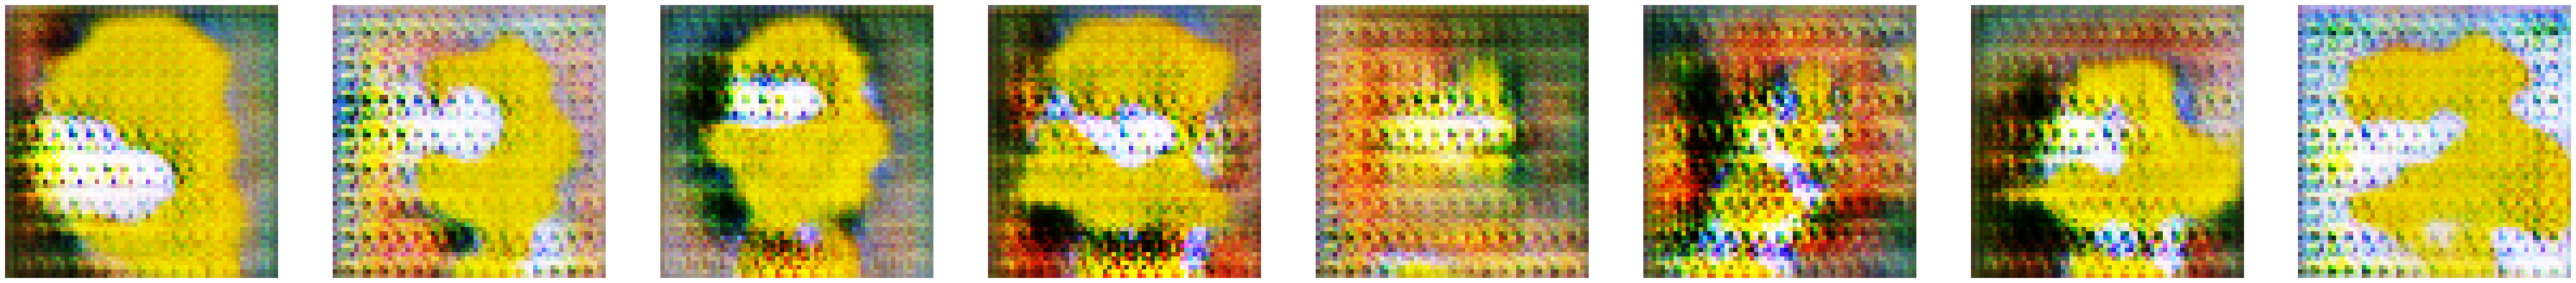

Epochs 27/40
Duration: 83.953
DISCRIMINATOR LOSS: 0.23392
GENERATOR LOSS: 3.00508


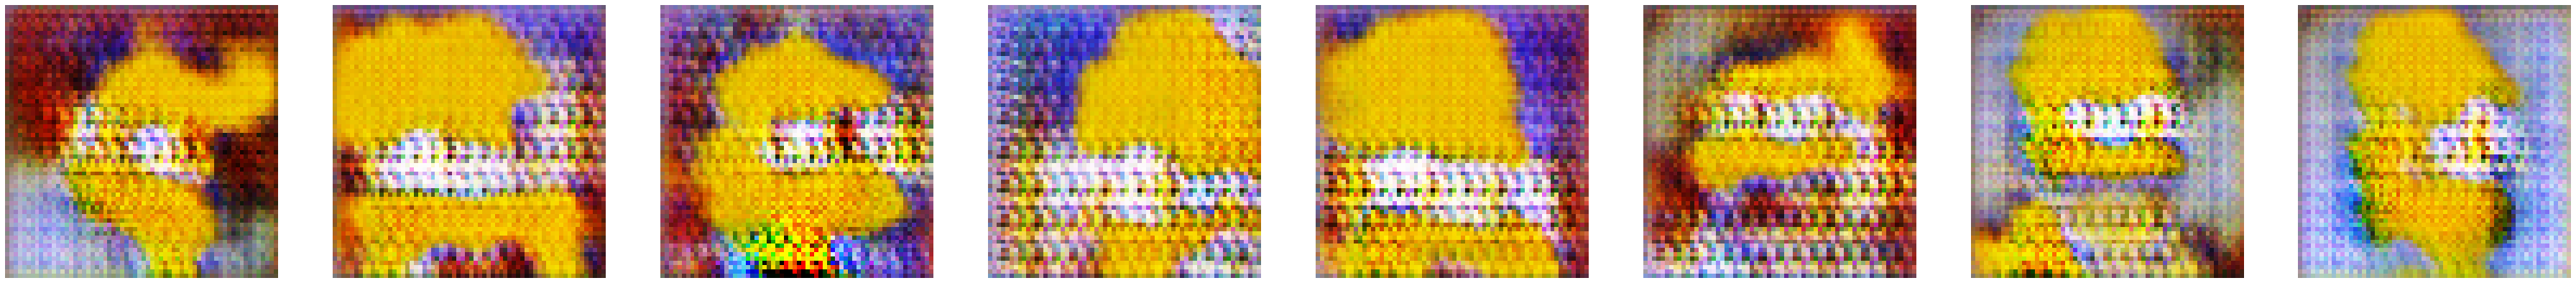

Epochs 28/40
Duration: 83.656
DISCRIMINATOR LOSS: 0.23419
GENERATOR LOSS: 3.00243


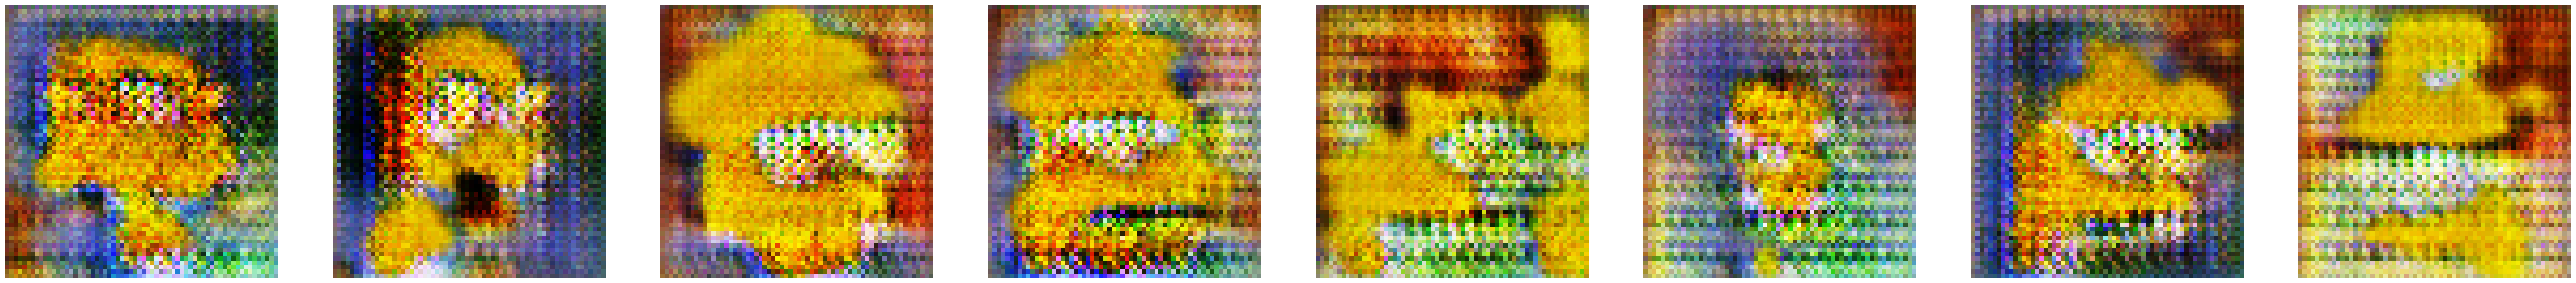

Epochs 29/40
Duration: 83.872
DISCRIMINATOR LOSS: 0.23476
GENERATOR LOSS: 2.99617


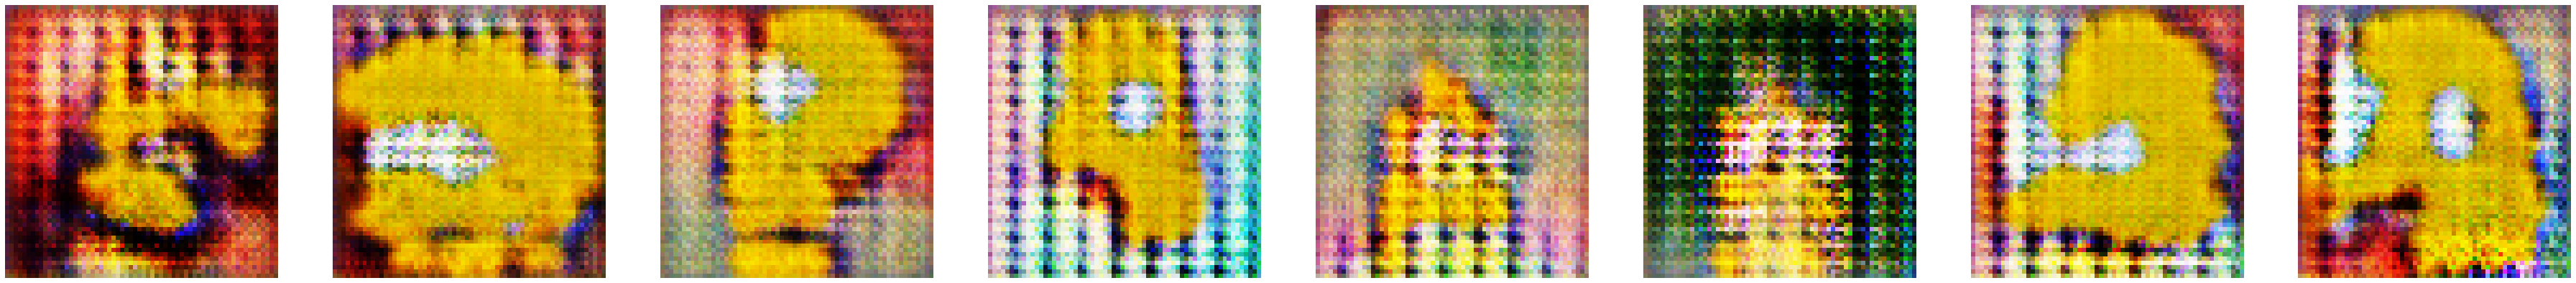

Epochs 30/40
Duration: 84.034
DISCRIMINATOR LOSS: 0.23497
GENERATOR LOSS: 2.98941


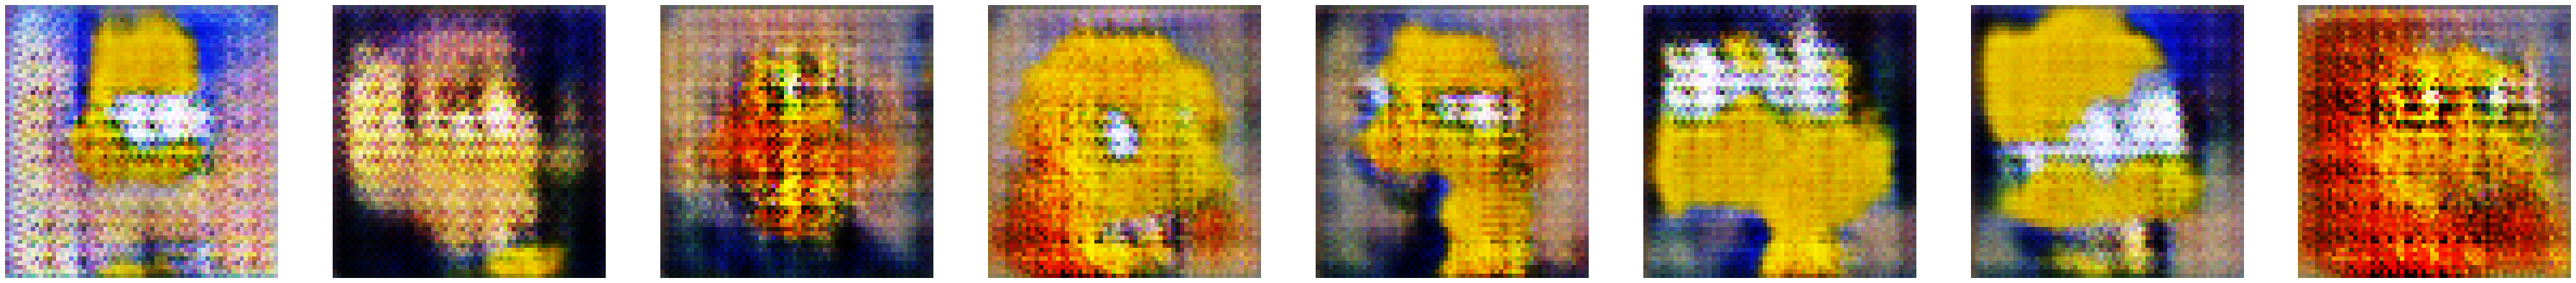

Epochs 31/40
Duration: 83.947
DISCRIMINATOR LOSS: 0.23552
GENERATOR LOSS: 2.98718


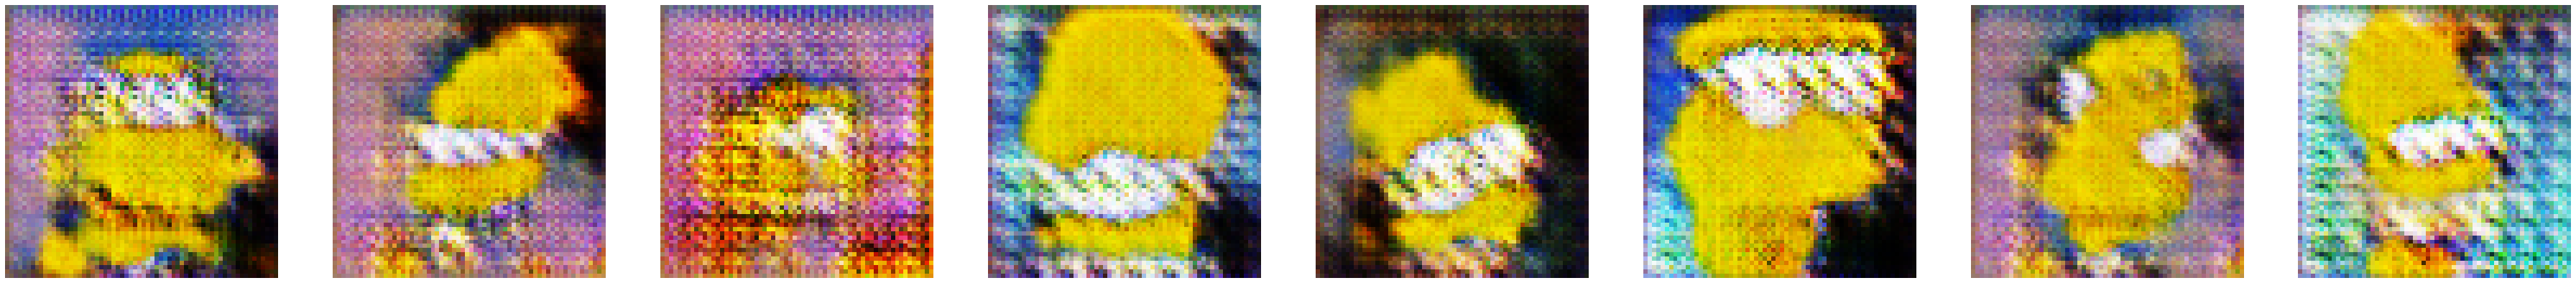

Epochs 32/40
Duration: 83.727
DISCRIMINATOR LOSS: 0.23610
GENERATOR LOSS: 2.98490


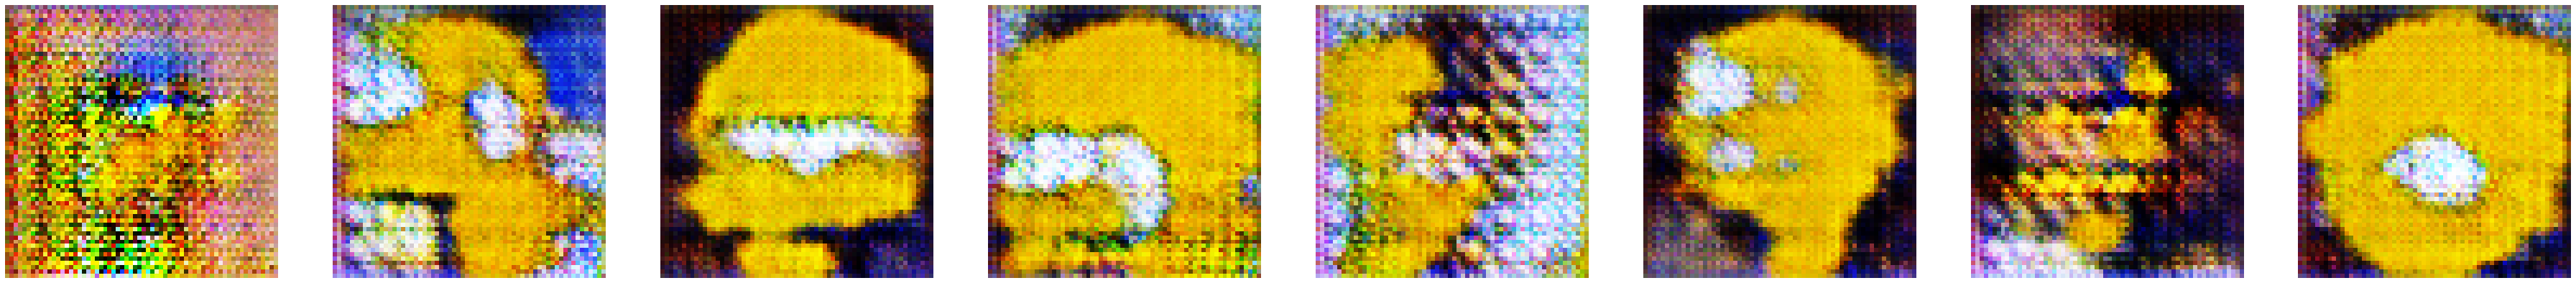

Epochs 33/40
Duration: 83.764
DISCRIMINATOR LOSS: 0.23641
GENERATOR LOSS: 2.98218


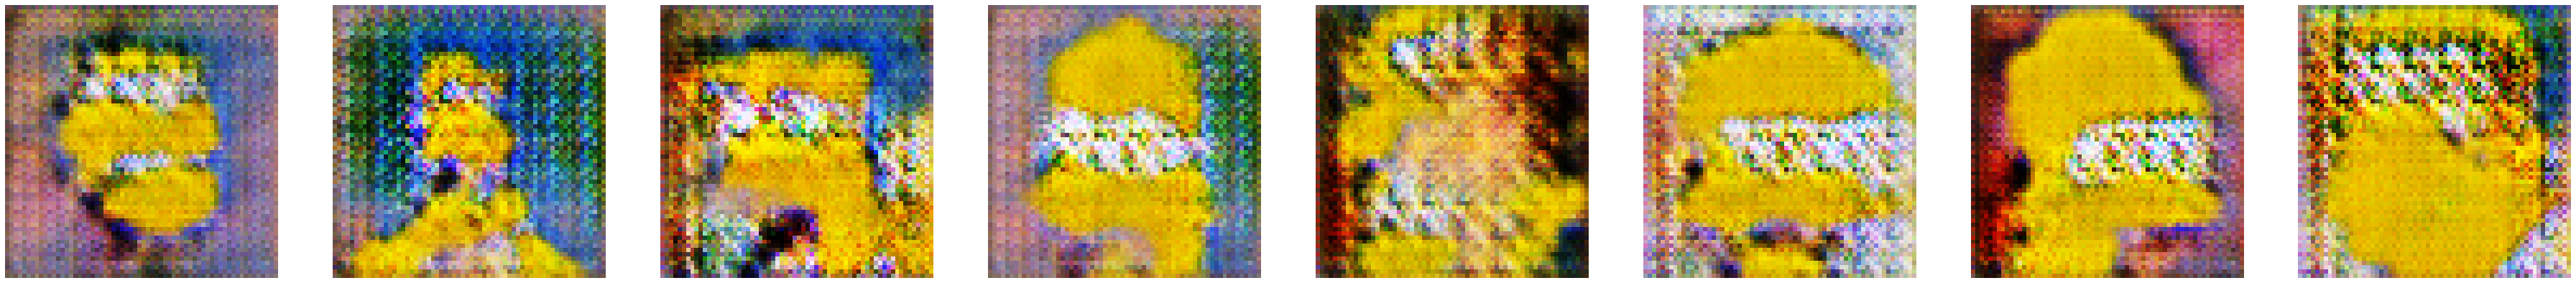

Epochs 34/40
Duration: 83.827
DISCRIMINATOR LOSS: 0.23668
GENERATOR LOSS: 2.97537


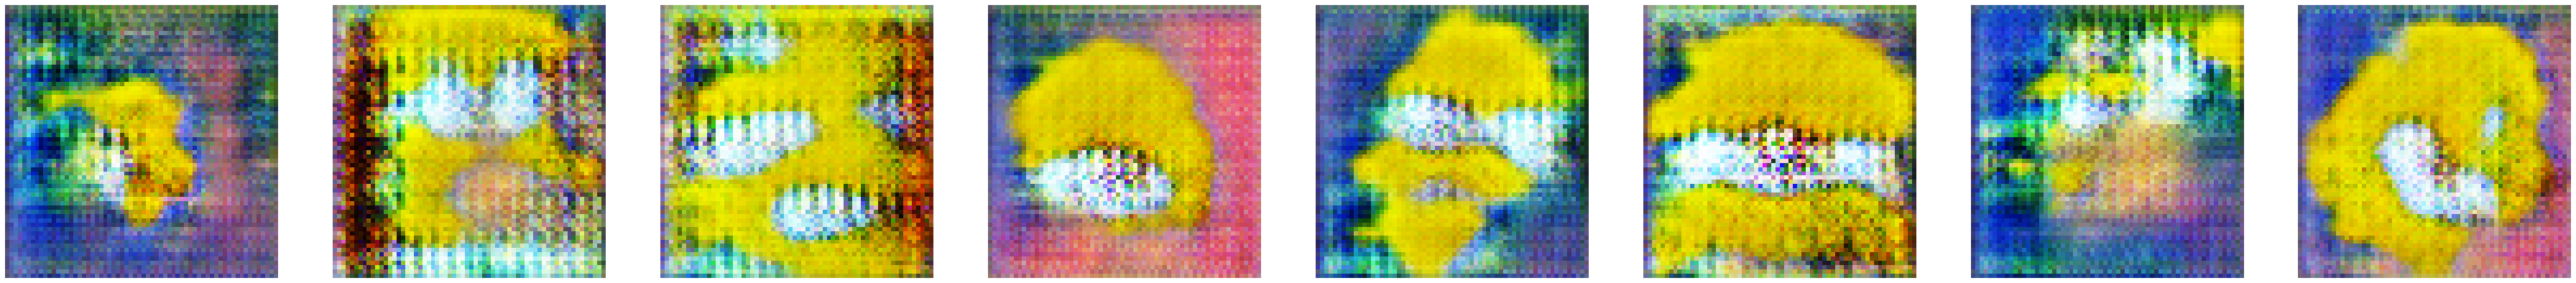

Epochs 35/40
Duration: 83.670
DISCRIMINATOR LOSS: 0.23689
GENERATOR LOSS: 2.97262


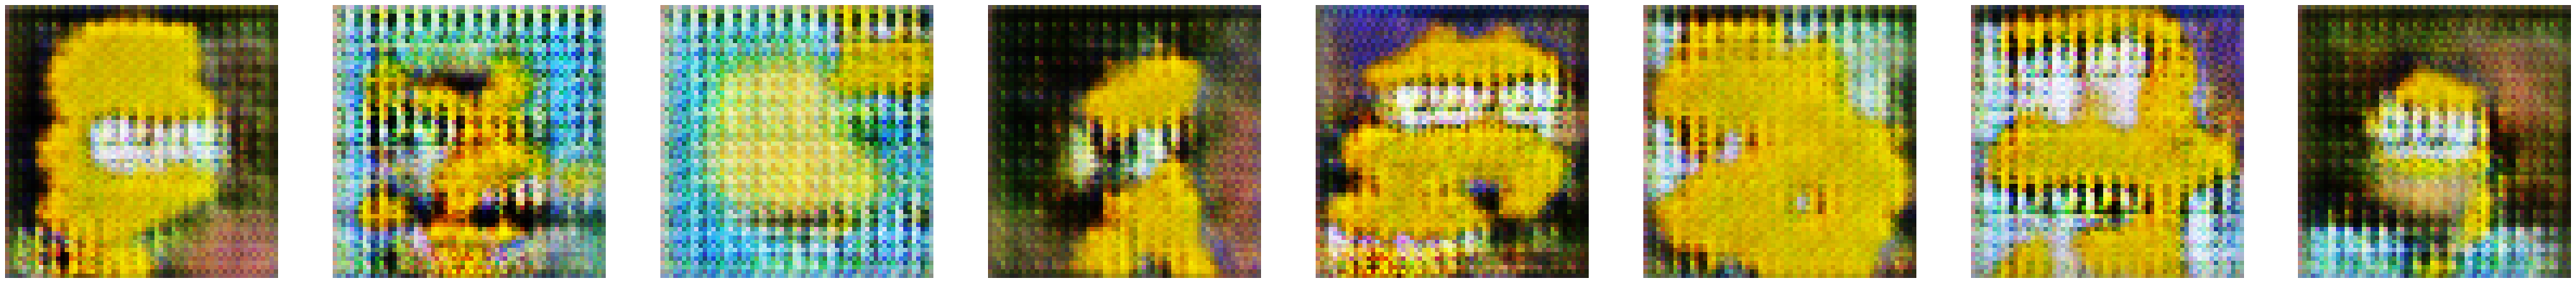

Epochs 36/40
Duration: 84.112
DISCRIMINATOR LOSS: 0.23702
GENERATOR LOSS: 2.96932


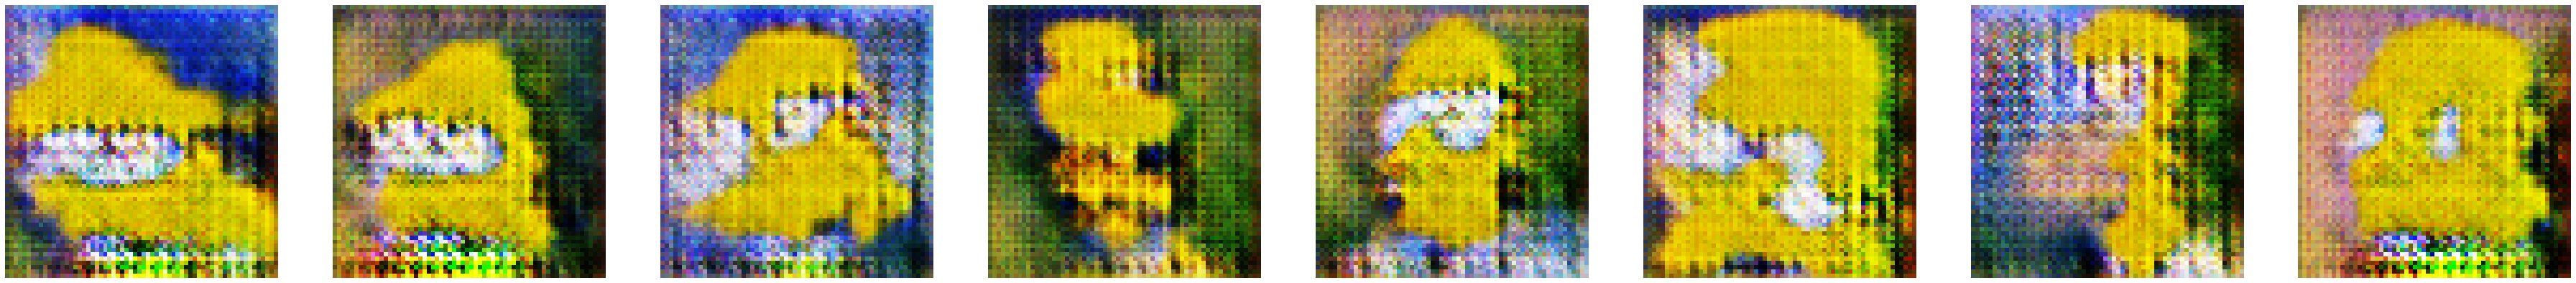

Epochs 37/40
Duration: 83.889
DISCRIMINATOR LOSS: 0.23766
GENERATOR LOSS: 2.96607


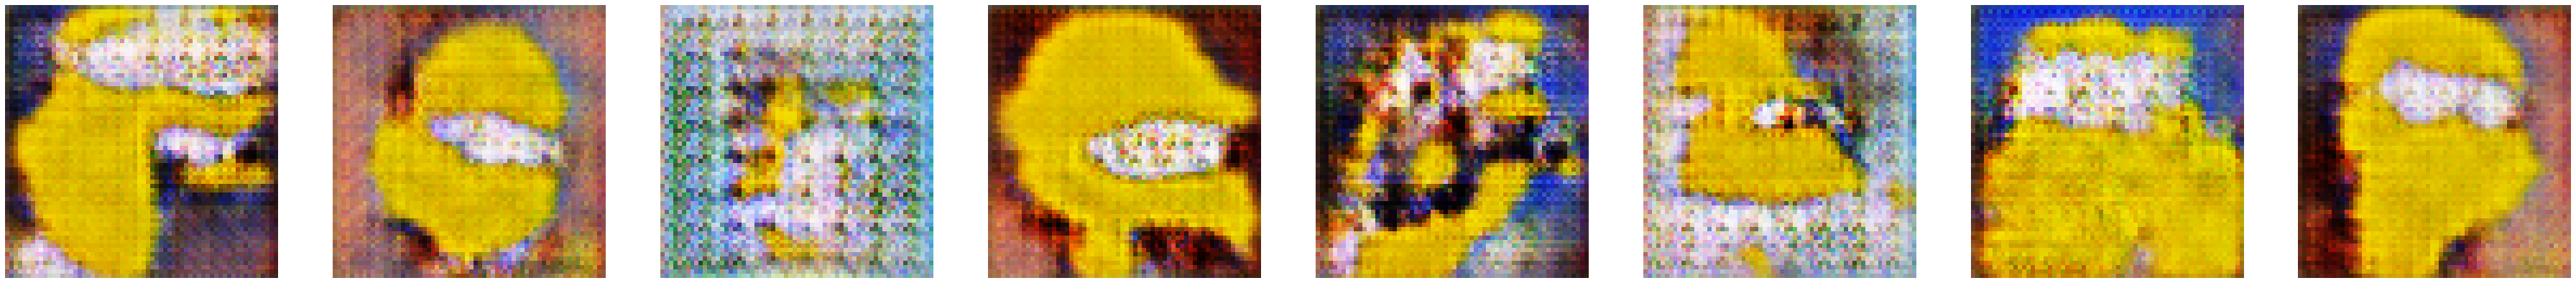

Epochs 38/40
Duration: 83.864
DISCRIMINATOR LOSS: 0.23852
GENERATOR LOSS: 2.96096


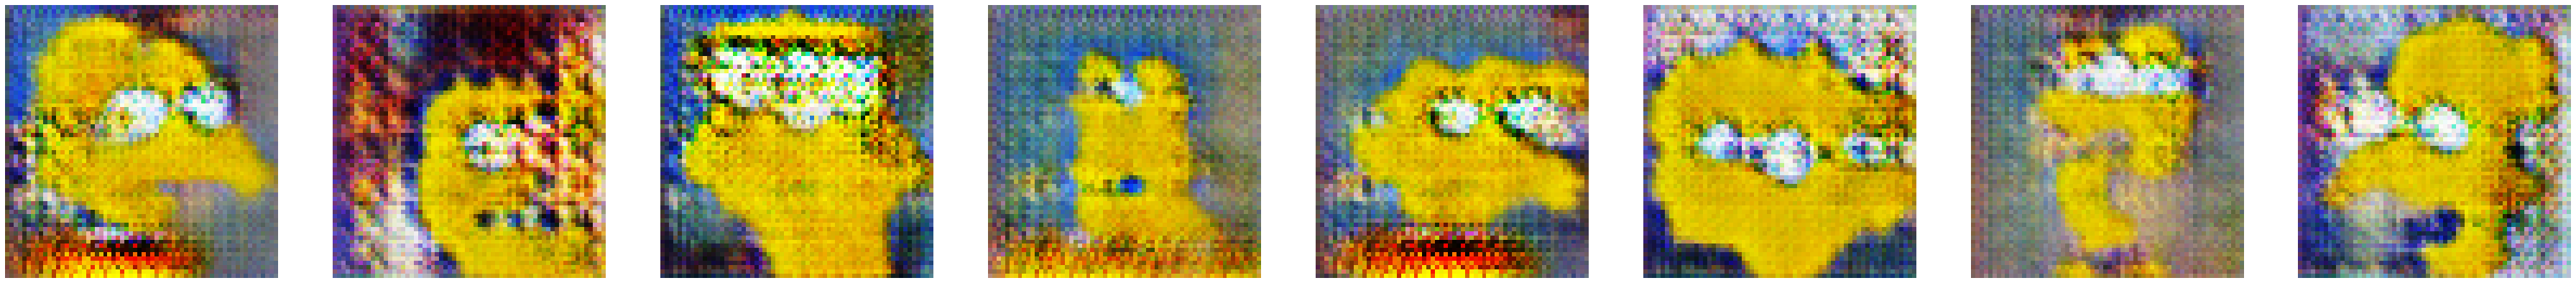

Epochs 39/40
Duration: 83.827
DISCRIMINATOR LOSS: 0.23913
GENERATOR LOSS: 2.95348


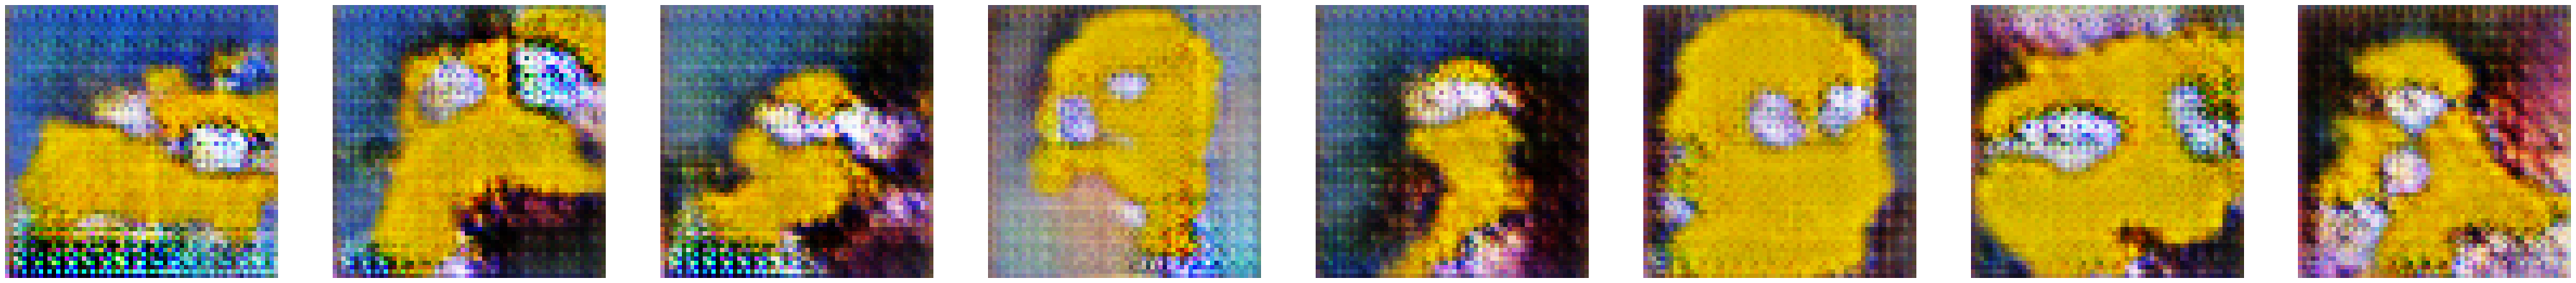

Epochs 40/40
Duration: 83.845
DISCRIMINATOR LOSS: 0.23951
GENERATOR LOSS: 2.94768


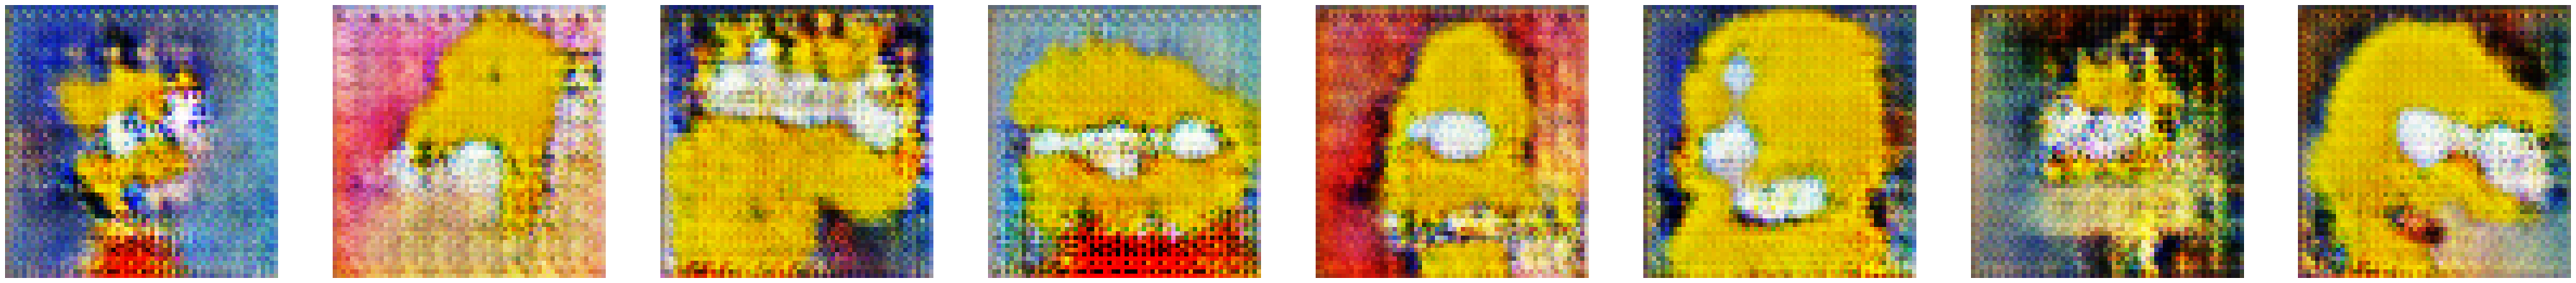

In [54]:
print("TRAINING BEGINS...")
warnings.filterwarnings("ignore")

d_losses=[]
g_losses=[]
cum_d_loss=0
cum_g_loss=0

for epoch in range(EPOCHS):
    epoch+=1
    start_time = time.time()
    
    for batch_images in get_batches(input_images):
        noise_data = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))
        generated_images = generator.predict(noise_data)
        
        #TRAIN DISCRIMINATOR
        
        real_labels = np.zeros((BATCH_SIZE,1)) + np.random.uniform(low=0.0,high=0.1,size=(BATCH_SIZE,1))
        
        #print("TRAINING DISCRIMINATOR ON REAL IMAGES")
        d_loss_real = discriminator.train_on_batch(batch_images,real_labels)
        
        fake_labels = np.ones((BATCH_SIZE,1)) - np.random.uniform(low=0.0,high=0.1,size=(BATCH_SIZE,1))
        
        #print("TRAINING DISCRIMINATOR ON FAKE IMAGES")
        d_loss_fake = discriminator.train_on_batch(generated_images,fake_labels)
        
        d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
        cum_d_loss+=d_loss
        d_losses.append(d_loss[0])
        
        #TRAIN GENERATOR
        
        noise_data = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))
        #print("TRAINING GENERATOR")
        g_loss = gan.train_on_batch(noise_data,np.zeros((BATCH_SIZE,1)))
        cum_g_loss+=g_loss
        g_losses.append(g_loss)
        
        file_path = 'C:\\Users\\AnKajVi\\Documents\\faces\\nnweight-weights'
        
#         if(epoch%10==0):
#             discriminator.save_weights(file_path)
#             gan.save_weights(file_path)
            
    summarize_epochs(d_losses,g_losses,input_images.shape,epoch,time.time()-start_time,noise_data)

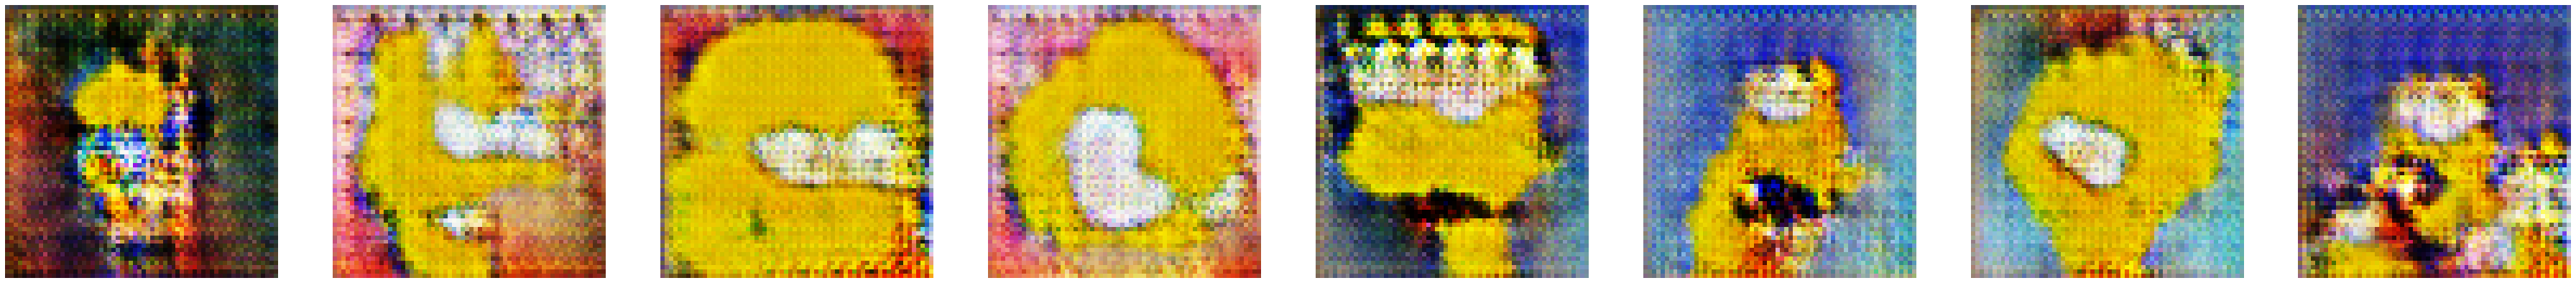

In [63]:
noise_data = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_SIZE))
test(noise_data)

In [58]:
from keras.models import model_from_json
model_generator_json = generator.to_json()
model_discriminator_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(model_discriminator_json)

In [59]:
with open("generator.json", "w") as json_file:
    json_file.write(model_generator_json)

In [60]:
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

In [62]:
os.getcwd()

'C:\\Users\\AnKajVi\\Documents\\faces'